→ optimal window=5000, threshold gt -0.280, max F1=0.764


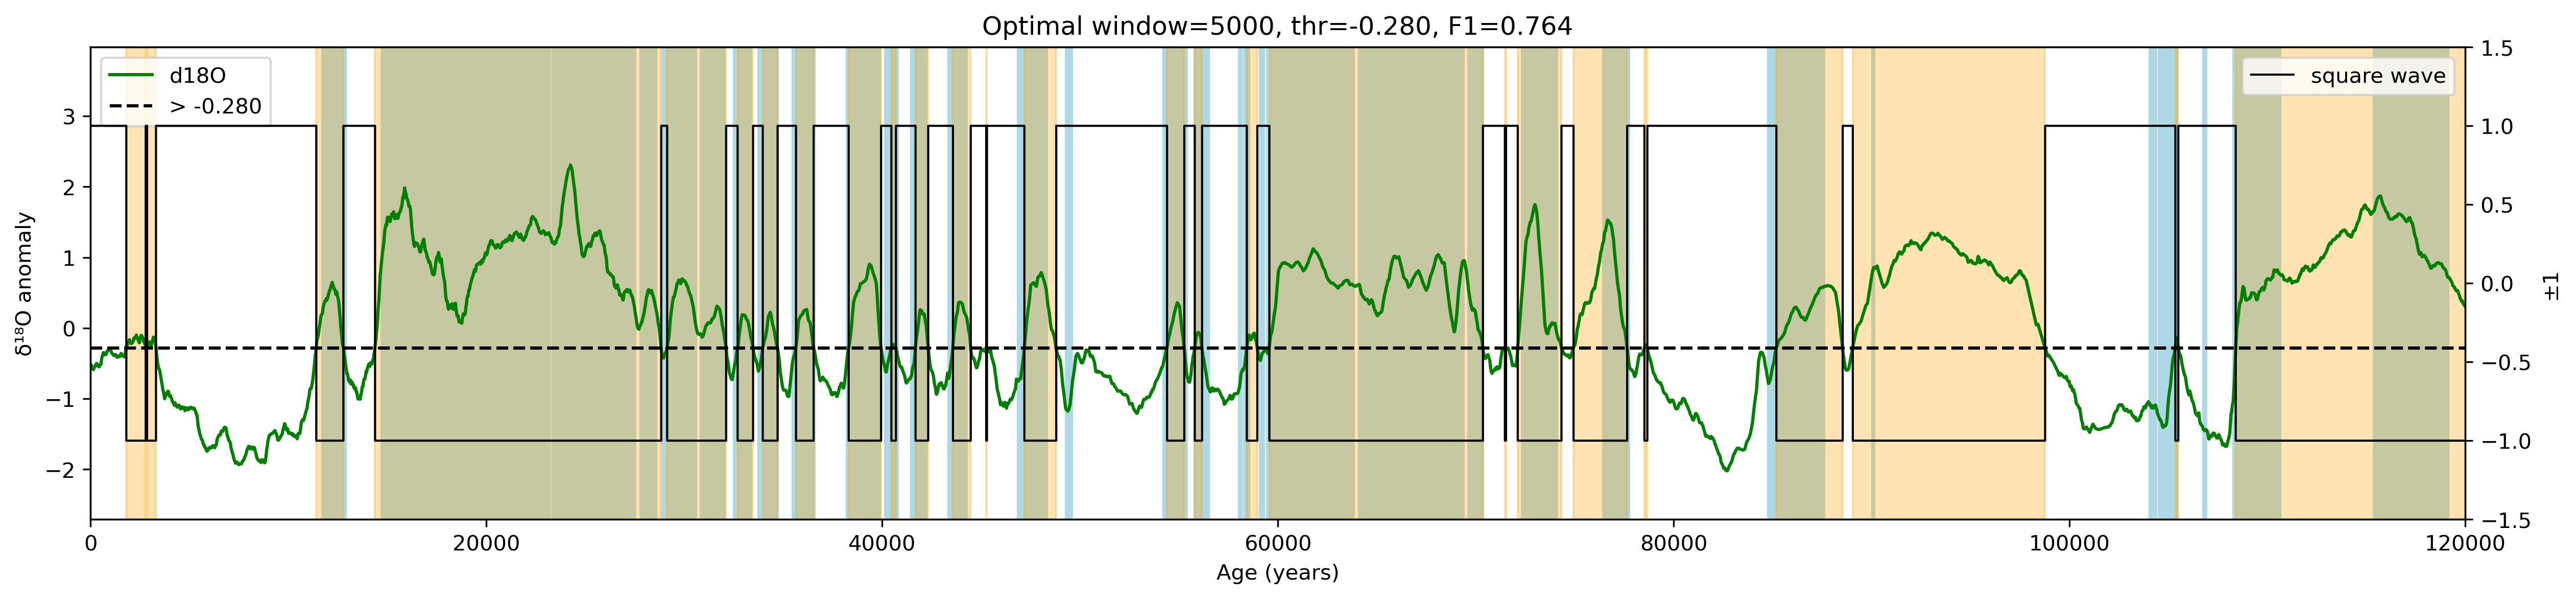

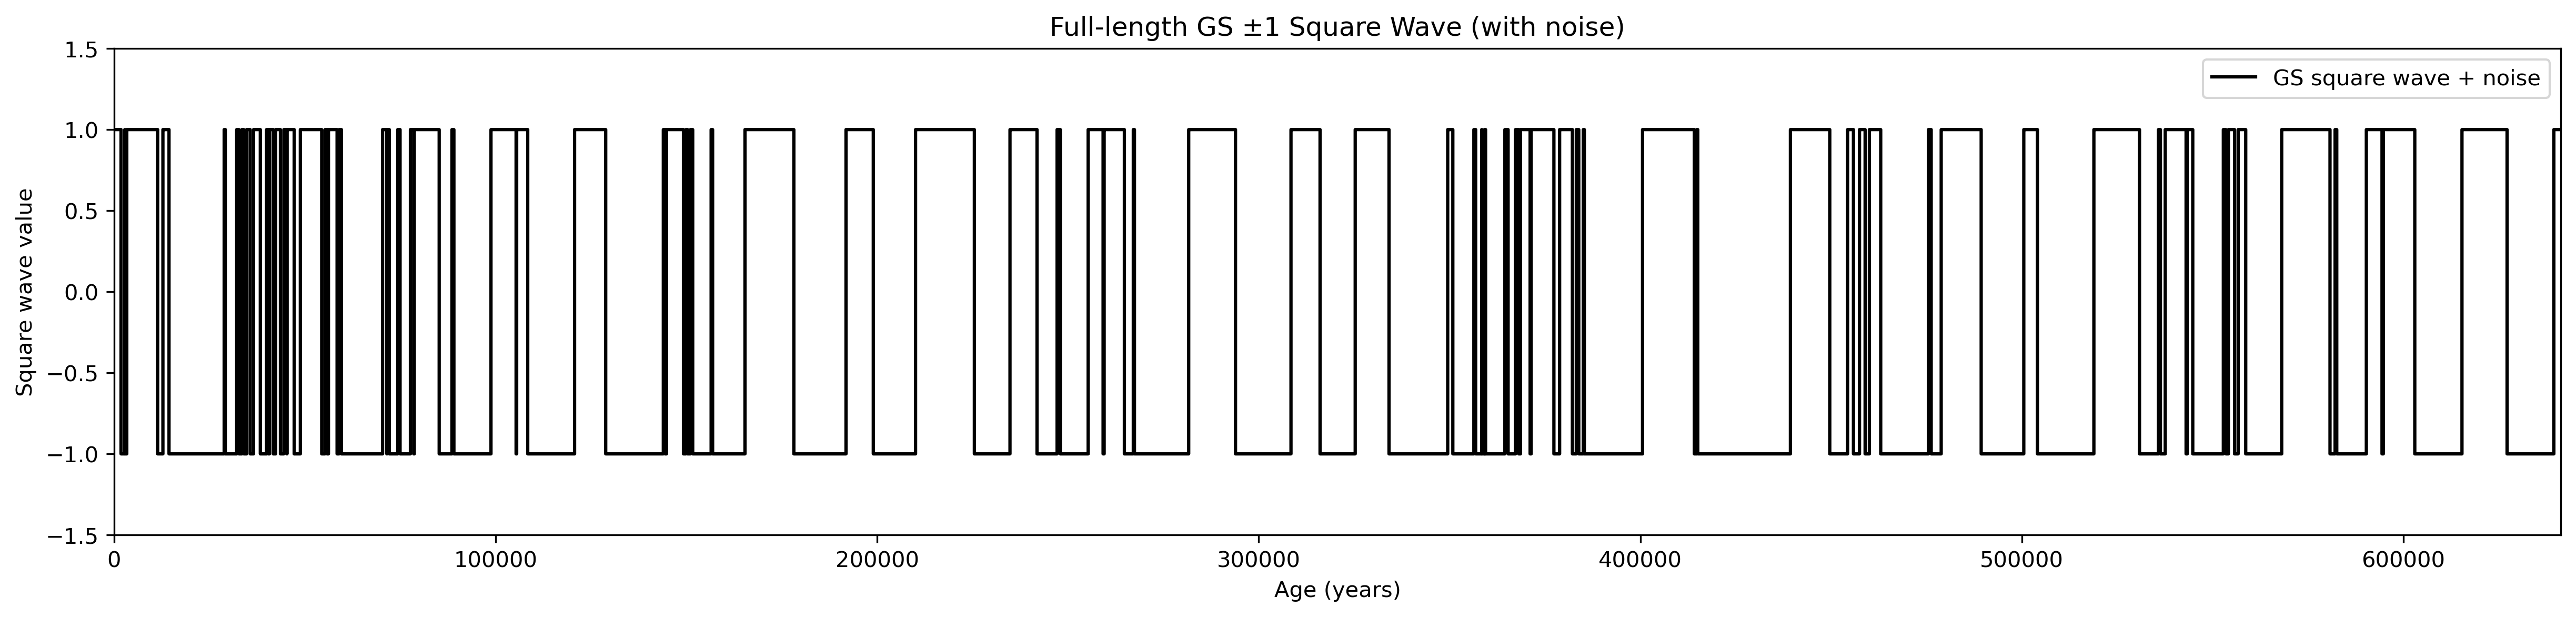

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
from scipy.interpolate import interp1d

# --- 0) load & interpolate as before ---
file_path = r"D:\VScode\bipolar_seesaw_CCM\other_data\monsoon.xlsx"
df = pd.read_excel(file_path)
df['age'] = df['age'] * 1000

# resample to 10-yr steps
new_age = np.arange(0, 641260, 10)
f = interp1d(df['age'], df['d18O'], kind='nearest',
             bounds_error=False, fill_value=1)
new_df = pd.DataFrame({
    'age': new_age,
    'd18O': f(new_age)
})

# --- 1) GS ground-truth table ---
gs_data = {
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040,104520,106750,108280,115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380,105440,106900,110640,119140]
}
# make ground truth mask on cropped (<120k yr)
mask_true_full = np.zeros_like(new_df['age'].values, dtype=bool)
for s, e in zip(gs_data["start"], gs_data["end"]):
    mask_true_full |= (new_df['age'] >= s) & (new_df['age'] <= e)

mask_true_crop = mask_true_full & (new_df['age'] < 120_000)

# F1 helper
def f1_score(pred, true):
    tp = np.sum(pred & true)
    fp = np.sum(pred & ~true)
    fn = np.sum(~pred & true)
    return 2*tp/(2*tp + fp + fn) if (2*tp + fp + fn)>0 else 0

# --- 2) grid‐search over window & threshold ---
window_range = np.arange(5_000, 20_001, 1_000)
thr_cands = np.linspace(-1, 1, 201)  # adjust range if needed

best = {'window':None, 'thr':None, 'dir':None, 'f1':-1}

for w in window_range:
    # low‐freq smoothing & anomaly
    smooth_lo = new_df['d18O'].rolling(window=w, center=True, min_periods=1).mean()
    anomaly = new_df['d18O'] - smooth_lo
    # optional 50-pt smoothing of anomaly
    anomaly_sm = anomaly.rolling(window=50, center=True, min_periods=1).mean()
    
    # crop to <120k for scoring
    vals = anomaly_sm.values[ new_df['age'] < 120_000 ]
    true = mask_true_crop[ new_df['age'] < 120_000 ]
    
    # scan threshold & direction
    for direction in ('gt','lt'):
        for thr in thr_cands:
            pred = (vals > thr) if direction=='gt' else (vals < thr)
            score = f1_score(pred, true)
            if score > best['f1']:
                best.update(window=w, thr=thr, dir=direction, f1=score)

print(f"→ optimal window={best['window']}, "
      f"threshold {best['dir']} {best['thr']:.3f}, "
      f"max F1={best['f1']:.3f}")

# --- 3) build final square wave over full record ---
lo = new_df['d18O'].rolling(window=best['window'],
                            center=True, min_periods=1).mean()
anom = new_df['d18O'] - lo
anom_sm = anom.rolling(window=50, center=True, min_periods=1).mean().values

if best['dir']=='gt':
    is_gs_pred = anom_sm > best['thr']
else:
    is_gs_pred = anom_sm < best['thr']

square_wave = np.where(is_gs_pred, -1, 1)

# --- fix here: build segments safely ---
ages_all = new_df['age'].values
segments = []
for val, grp in groupby(enumerate(is_gs_pred), key=lambda x: x[1]):
    if val:
        grp_list = list(grp)
        start_idx = grp_list[0][0]
        end_idx   = grp_list[-1][0]
        segments.append((ages_all[start_idx], ages_all[end_idx]))


# --- 4) plot final result ---
fig, ax = plt.subplots(figsize=(20,4), dpi=300)

# official GS spans
for s,e in zip(gs_data["start"], gs_data["end"]):
    ax.axvspan(s, e, color='lightblue', alpha=1, zorder=0)
# predicted spans
for s,e in segments:
    ax.axvspan(s, e, color='orange', alpha=0.3, zorder=1)

# δ18O anomaly curve
ax.plot(new_df['age'], anom_sm, color='green', label='d18O')

# threshold line
thr_line = best['thr']
ax.axhline(thr_line, linestyle='--', color='black',
           label=f"{'>' if best['dir']=='gt' else '<'} {thr_line:.3f}")

# square wave inset
ax2 = ax.twinx()
ax2.plot(ages_all, square_wave, drawstyle='steps-post',
         color='black', linewidth=1, label='square wave')
ax2.set_ylim(-1.5,1.5)
ax2.set_ylabel('±1')

ax.invert_xaxis()  # if you want age decreasing left→right
ax.set_xlim(0,120000)
ax.set_xlabel('Age (years)')
ax.set_ylabel('δ¹⁸O anomaly')
ax.set_title(f"Optimal window={best['window']}, thr={best['thr']:.3f}, F1={best['f1']:.3f}")
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()



# 2) Recreate df_sq exactly as in your original code
df_sq = pd.DataFrame({'age': ages_all, 'sq': square_wave})
white_noise = np.random.normal(0, 0.1, len(square_wave))
df_sq['sq'] = df_sq['sq'] #+ white_noise

# 3) Plot full‐length noisy square wave
fig, ax = plt.subplots(figsize=(20, 4), dpi=300)
ax.plot(df_sq['age'],
        df_sq['sq'],
        drawstyle='steps-post',
        color='black',
        linewidth=1.5,
        label='GS square wave + noise')
ax.set_ylim(min(square_wave) - 0.5, max(square_wave) + 0.5)
ax.set_xlim(df_sq['age'].min(), df_sq['age'].max())  # 0 → 641260
ax.set_xlabel('Age (years)')
ax.set_ylabel('Square wave value')
ax.set_title('Full‐length GS ±1 Square Wave (with noise)')
ax.legend(loc='upper right')
plt.show()


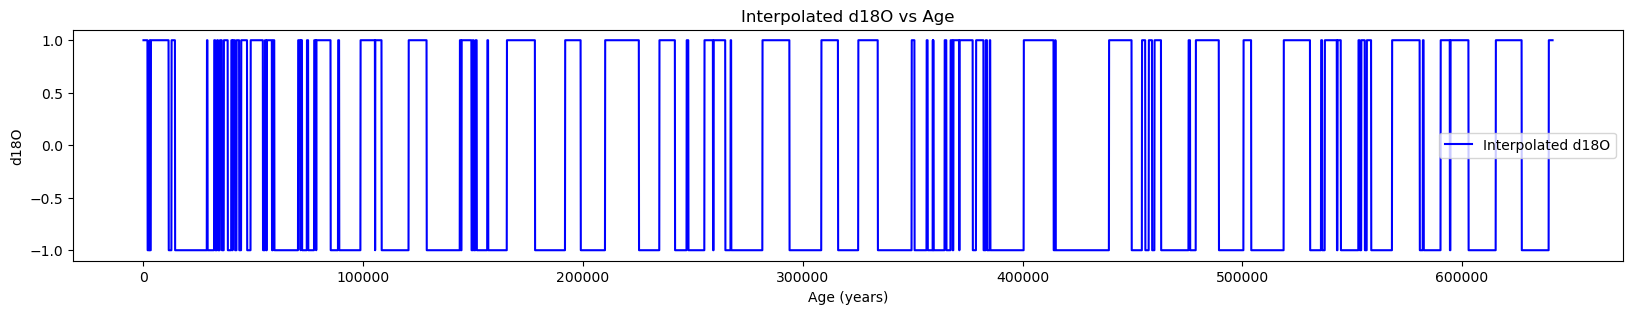

         age       pre
0          0  0.016280
1        100  0.016431
2        200  0.016568
3        300  0.016690
4        400  0.016798
...      ...       ...
6408  640800 -0.004129
6409  640900 -0.004396
6410  641000 -0.004658
6411  641100 -0.004917
6412  641200 -0.005173

[6413 rows x 2 columns]


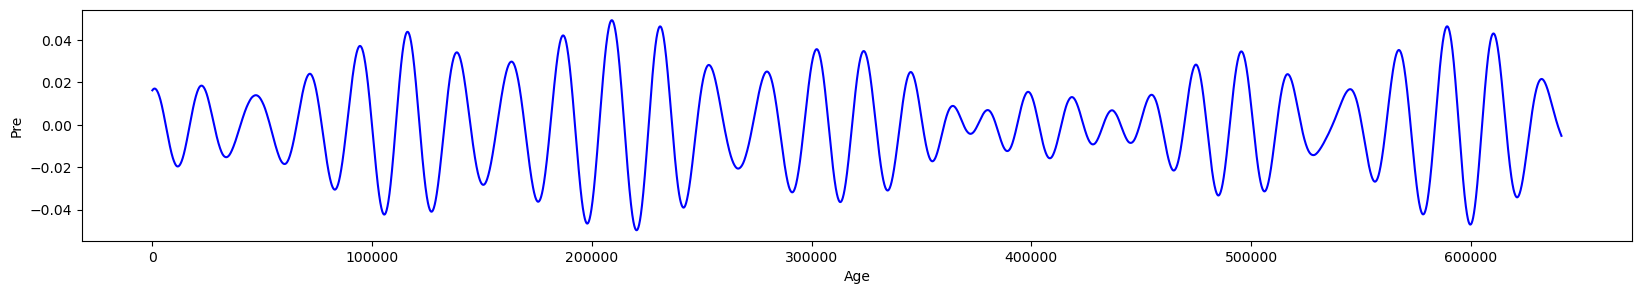

         age       obl
0          0  0.409093
1        100  0.409320
2        200  0.409547
3        300  0.409773
4        400  0.410000
...      ...       ...
6408  640800  0.399098
6409  640900  0.399136
6410  641000  0.399176
6411  641100  0.399218
6412  641200  0.399263

[6413 rows x 2 columns]


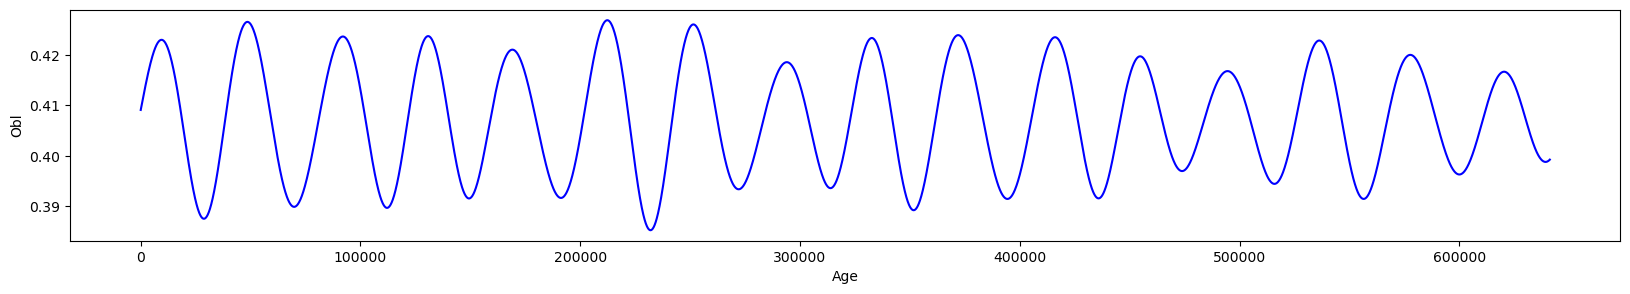

In [13]:
import pandas as pd
from scipy.interpolate import interp1d

# for df_sq, interpolated it to has 100 times lower resolution
new_age = np.arange(np.min(df_sq['age'].values), np.max(df_sq['age'].values), 100)
# create a new DataFrame with the new age values
f_sq = interp1d(df_sq['age'], df_sq['sq'], kind='nearest',
             bounds_error=False,
             fill_value=1)
interpolated_sq = f_sq(new_age)
# create a new DataFrame with the new age values
df_sq = pd.DataFrame({'age': new_age, 'sq': interpolated_sq})

# plot the data
plt.figure(figsize=(20, 3))
plt.plot(df_sq['age'], df_sq['sq'], label='Interpolated d18O', color='blue')
plt.xlabel('Age (years)')
plt.ylabel('d18O')
plt.title('Interpolated d18O vs Age')
plt.legend()
plt.show()

# # filp the second column upside down (last row to first row)
# df_sq['sq'] = df_sq['sq'].iloc[::-1].reset_index(drop=True)
# # plot the data
# plt.figure(figsize=(20, 3))
# plt.plot(df_sq['age'], df_sq['sq'], label='Interpolated d18O', color='blue')
# plt.xlabel('Age (years)')
# plt.ylabel('d18O')
# plt.title('Interpolated d18O vs Age')
# plt.legend()
# plt.show()




# Read the file into a DataFrame
df_pre = pd.read_csv(
    r"D:\VScode\bipolar_seesaw_CCM\inso_data\pre_800_inter100.txt", 
    sep='\s+',       # '\s+' means "split on any whitespace"
    header=None,     # or specify a row number if there's a header
    engine='python'
)

df_obl = pd.read_csv(
    r"D:\VScode\bipolar_seesaw_CCM\inso_data\obl_800_inter100.txt", 
    sep='\s+',       # '\s+' means "split on any whitespace"
    header=None,     # or specify a row number if there's a header
    engine='python'
)

df_pre.iloc[:, 0] = df_pre.iloc[:, 0].abs() * 1000
df_obl.iloc[:, 0] = df_obl.iloc[:, 0].abs() * 1000


# # plot df_pre
# plt.figure(figsize=(20, 3))
# plt.plot(df_pre.iloc[:, 0], df_pre.iloc[:, 1], label='pre', color='blue')
# plt.xlabel("Age")
# plt.ylabel("Pre")
# print(df_pre)
# plt.show()

# Reverse the DataFrame rows
df_pre = df_pre.iloc[::-1]
df_pre.columns = ['age', 'pre']

df_obl = df_obl.iloc[::-1]
df_obl.columns = ['age', 'obl']


# interpolate the data using new_age
f = interp1d(df_pre['age'], df_pre['pre'], kind='nearest',
             bounds_error=False,
             fill_value=1)

interpolated_pre = f(new_age)
df_pre = pd.DataFrame({'age': new_age, 'pre': interpolated_pre})

f = interp1d(df_obl['age'], df_obl['obl'], kind='nearest',
             bounds_error=False,
             fill_value=1)

interpolated_obl = f(new_age)
df_obl = pd.DataFrame({'age': new_age, 'obl': interpolated_obl})

# plot df_pre
plt.figure(figsize=(20, 3))
plt.plot(df_pre.iloc[:, 0], df_pre.iloc[:, 1], label='pre', color='blue')
plt.xlabel("Age")
plt.ylabel("Pre")
print(df_pre)
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(df_obl.iloc[:, 0], df_obl.iloc[:, 1], label='obl', color='blue')
plt.xlabel("Age")
plt.ylabel("Obl")
print(df_obl)
plt.show()

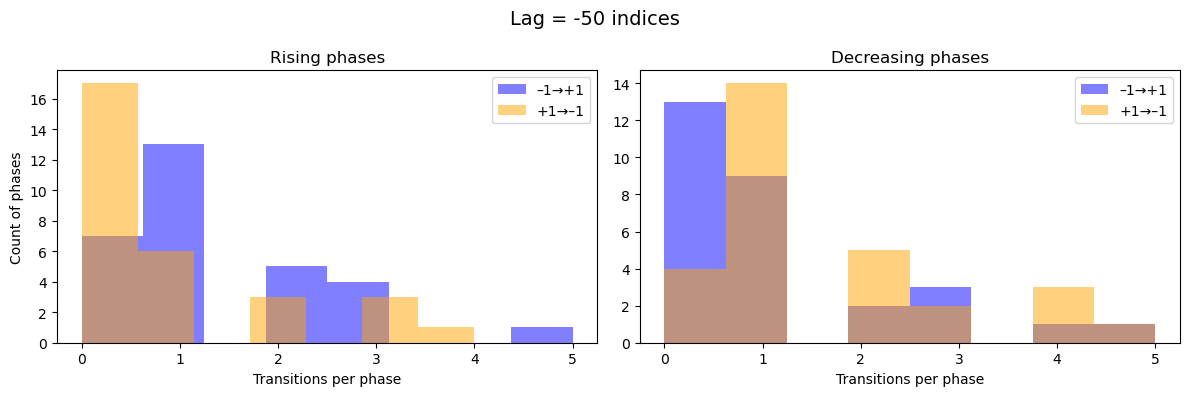

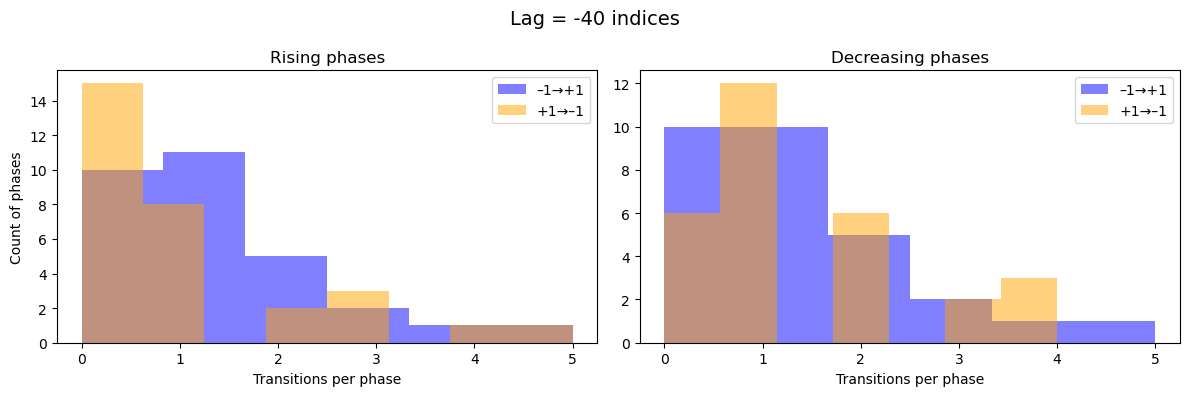

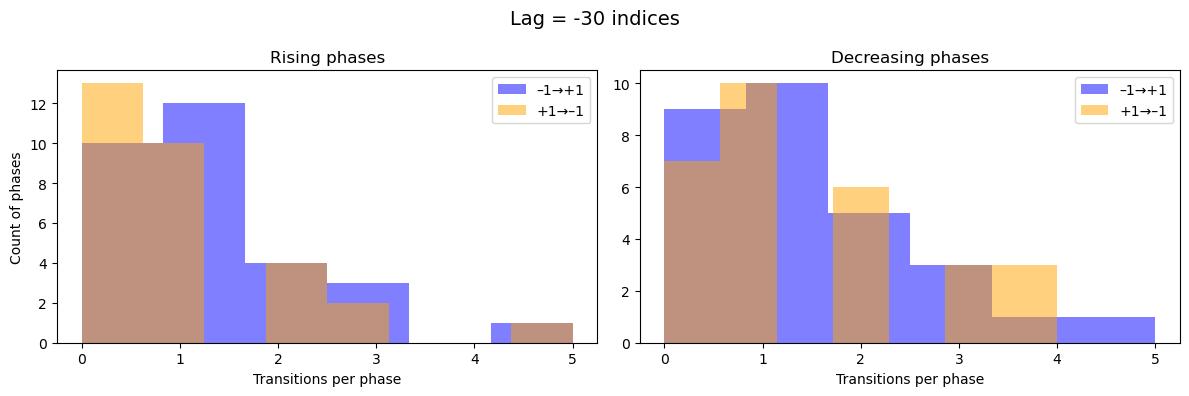

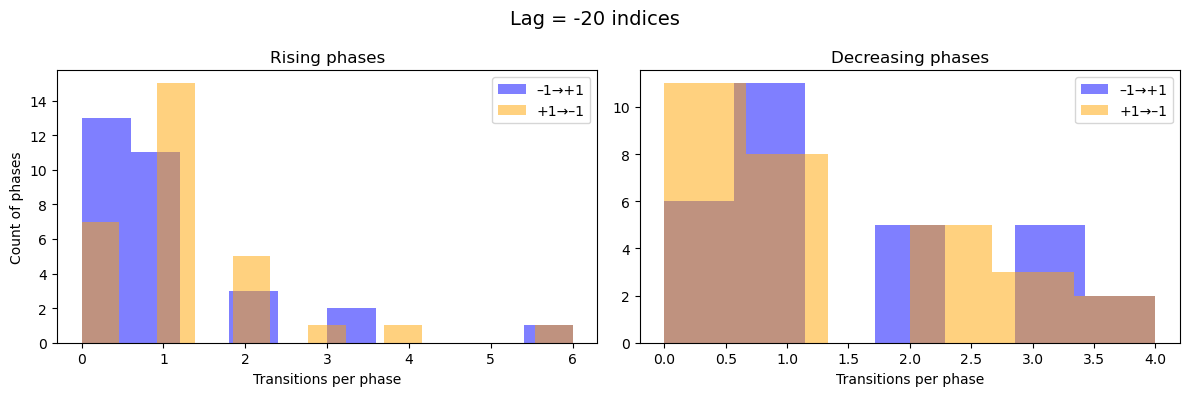

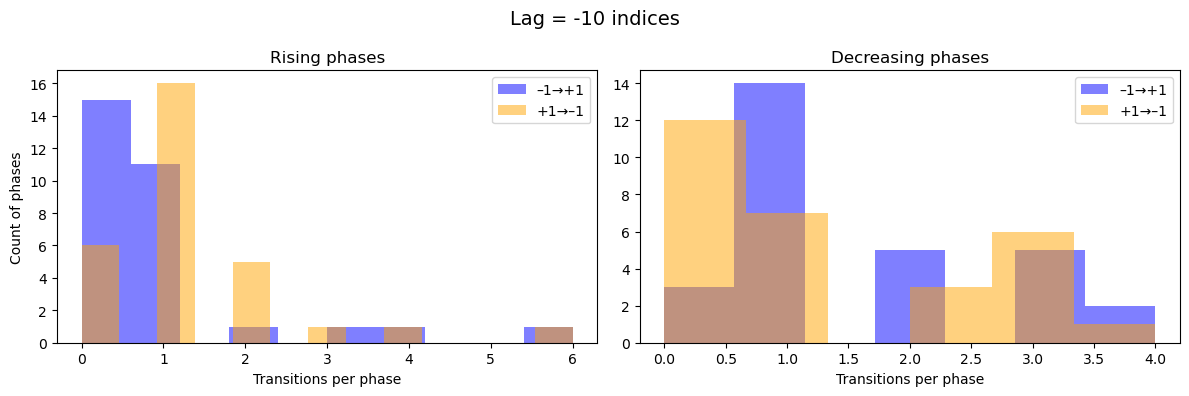

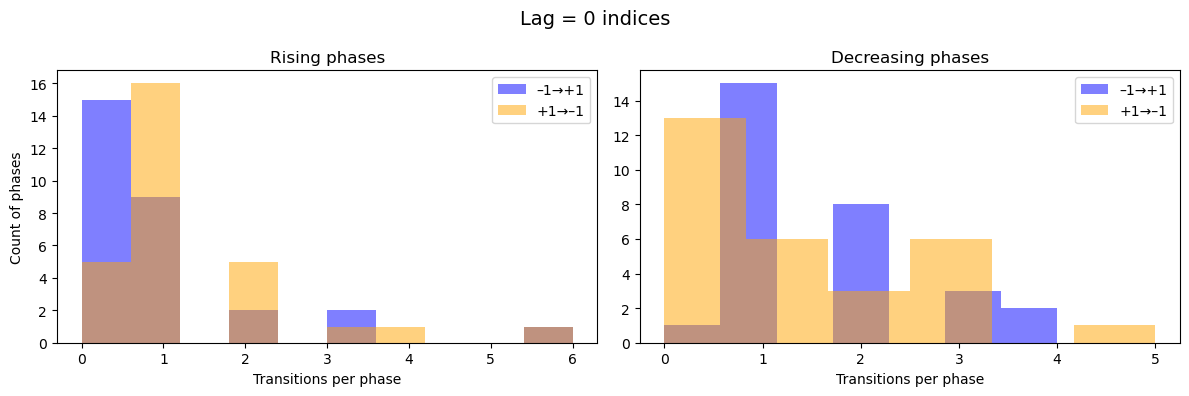

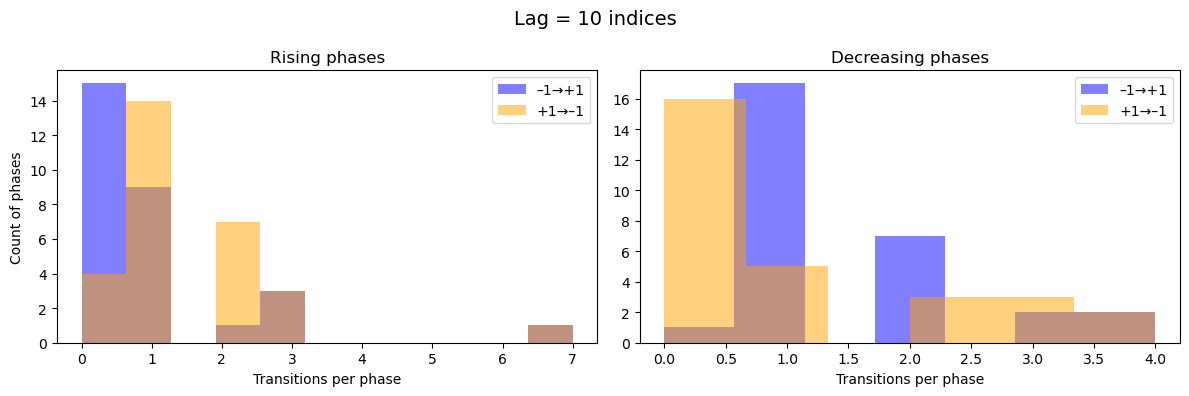

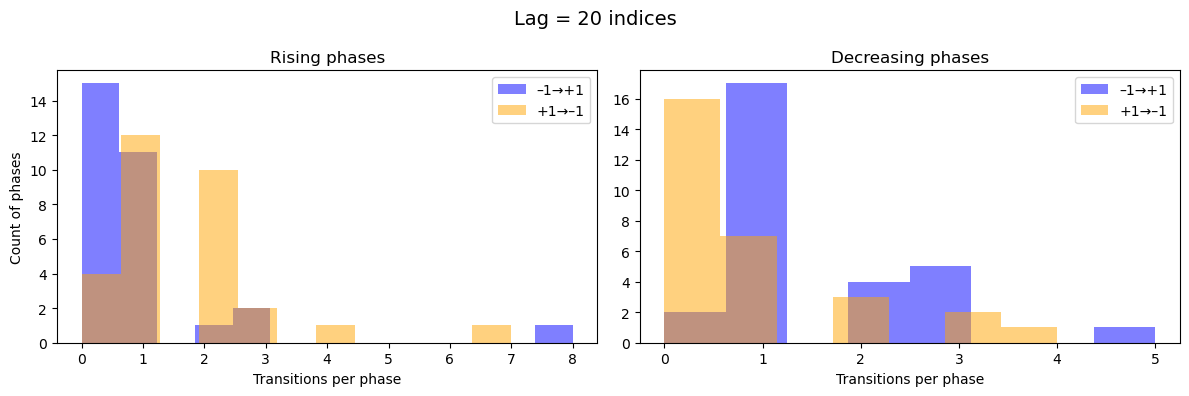

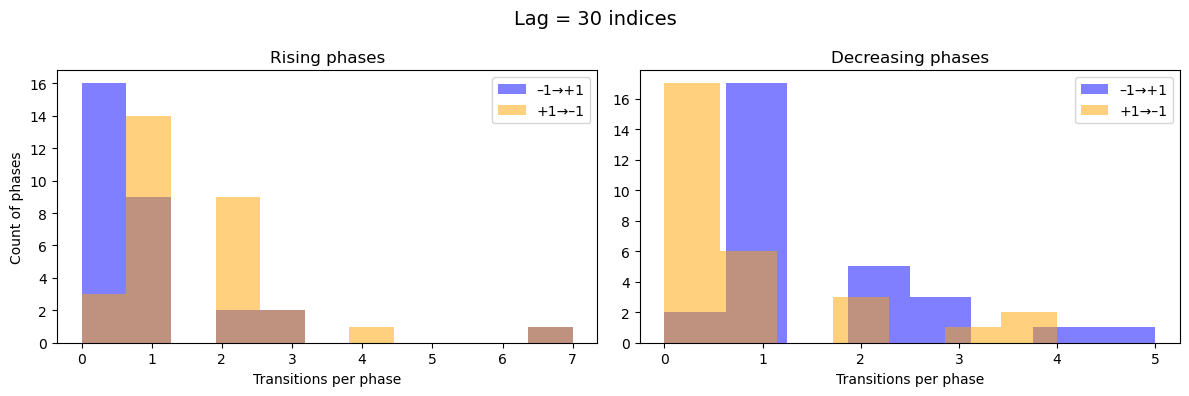

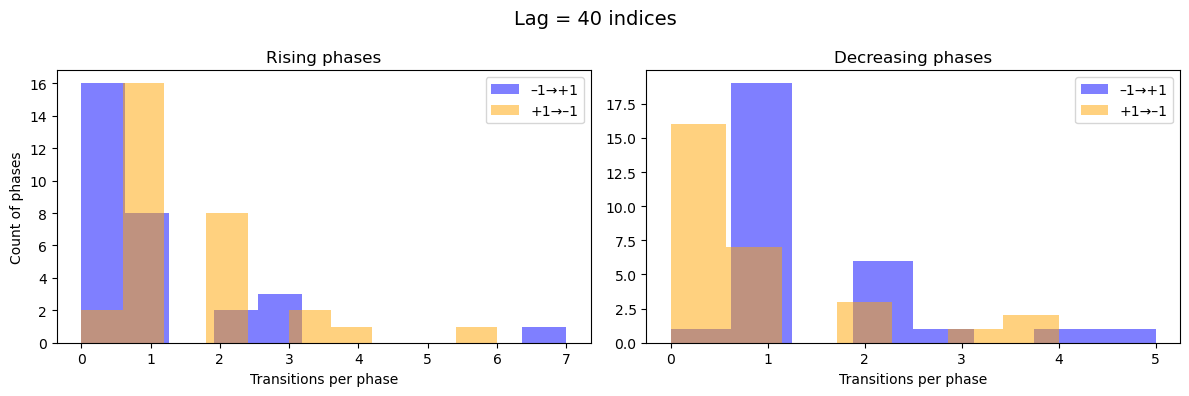

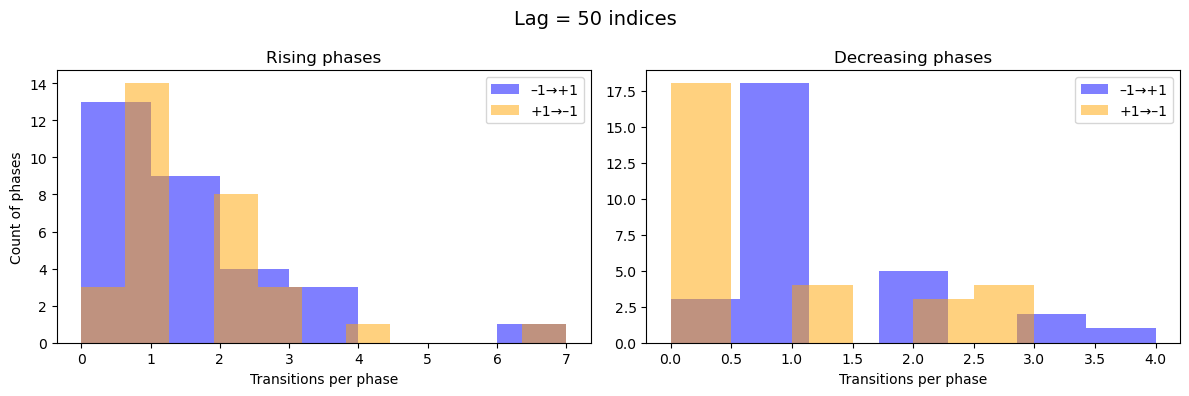

In [15]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# original arrays
pre_vals_orig = df_pre['pre'].values
sq_sign      = np.where(df_sq['sq'].values > 0, 1, -1)

def count_transitions(intervals, sq_sign):
    lt, hl = [], []
    for i0, i1 in intervals:
        seg = sq_sign[i0:i1+1]
        lt.append(np.sum((seg[:-1]==-1)&(seg[1:]==+1)))
        hl.append(np.sum((seg[:-1]==+1)&(seg[1:]==-1)))
    return lt, hl

# loop over lags
for lag in range(-50, 51, 10):
    # 1) shift precession
    pre_shifted = np.roll(pre_vals_orig, -lag)
    
    # 2) find peaks & troughs on shifted data
    peaks, _   = find_peaks(pre_shifted)
    troughs, _= find_peaks(-pre_shifted)
    
    # 3) rising intervals: trough → next peak
    rising   = []
    for t in troughs:
        next_p = peaks[peaks > t]
        if next_p.size:
            rising.append((t, next_p[0]))
    
    # 4) decreasing intervals: peak → next trough
    falling  = []
    for p in peaks:
        next_t = troughs[troughs > p]
        if next_t.size:
            falling.append((p, next_t[0]))
    
    # 5) count transitions
    r_lt, r_hl = count_transitions(rising,   sq_sign)
    f_lt, f_hl = count_transitions(falling,  sq_sign)
    
    # 6) plot 1×2
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
    fig.suptitle(f"Lag = {lag} indices", fontsize=14)
    
    # rising
    ax1.hist(r_lt, bins='auto', alpha=0.5, color='blue',  label='–1→+1')
    ax1.hist(r_hl, bins='auto', alpha=0.5, color='orange',label='+1→–1')
    ax1.set_title('Rising phases')
    ax1.set_xlabel('Transitions per phase')
    ax1.set_ylabel('Count of phases')
    ax1.legend()
    
    # falling
    ax2.hist(f_lt, bins='auto', alpha=0.5, color='blue',  label='–1→+1')
    ax2.hist(f_hl, bins='auto', alpha=0.5, color='orange',label='+1→–1')
    ax2.set_title('Decreasing phases')
    ax2.set_xlabel('Transitions per phase')
    ax2.legend()
    
    plt.show()


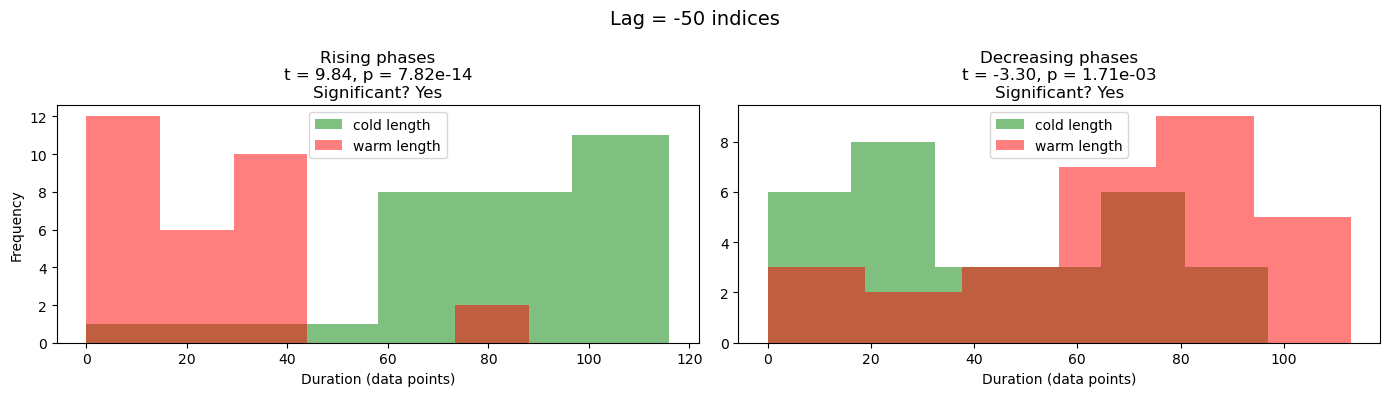

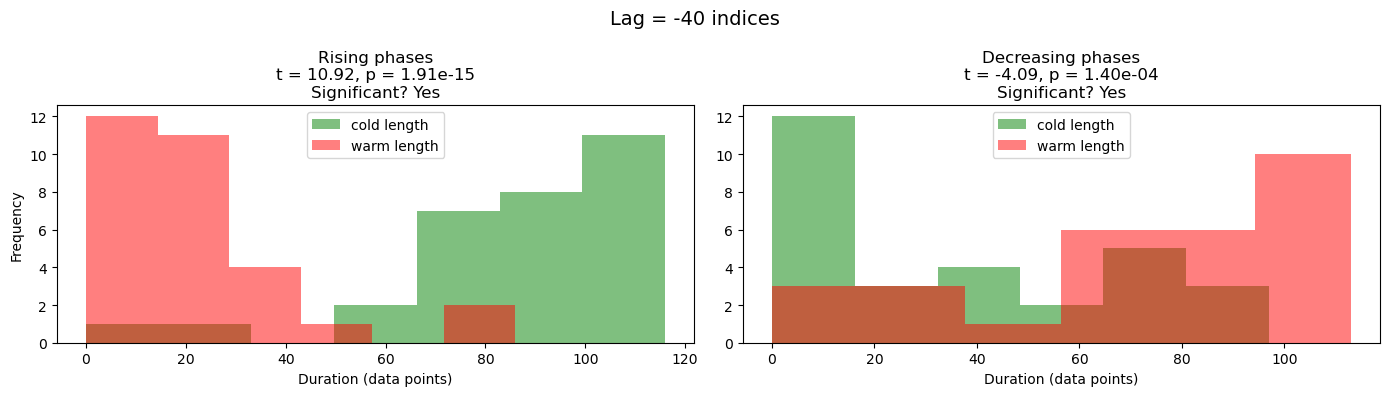

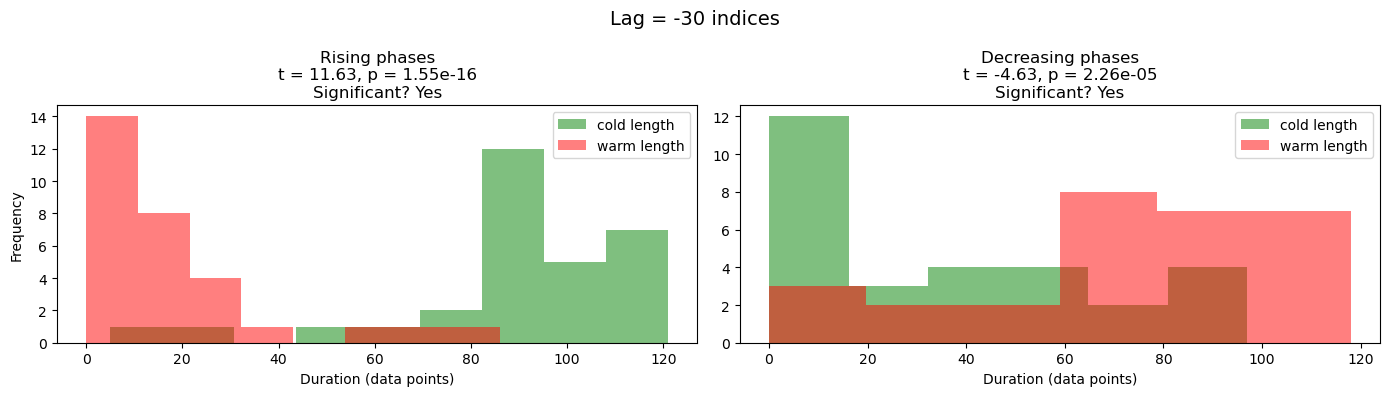

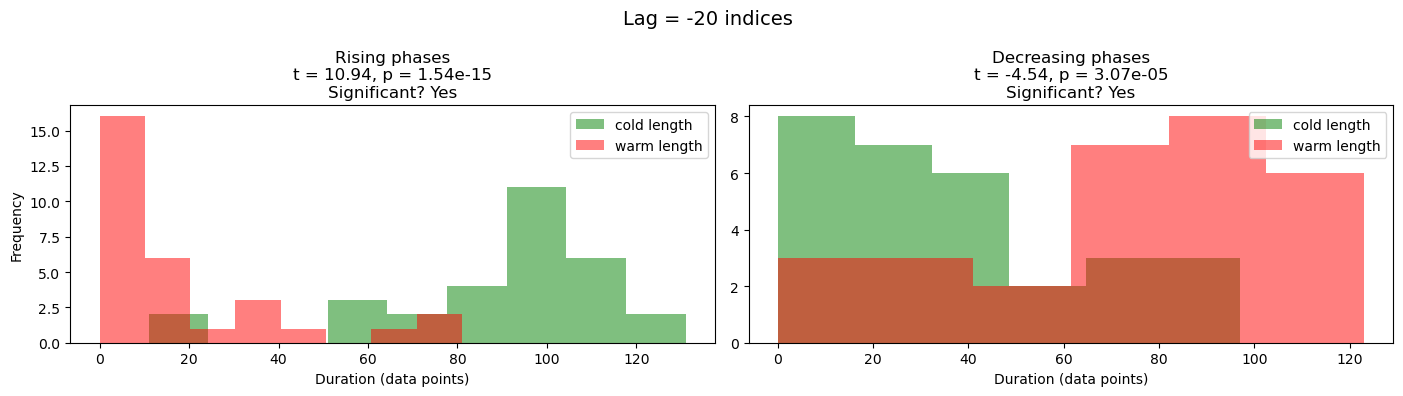

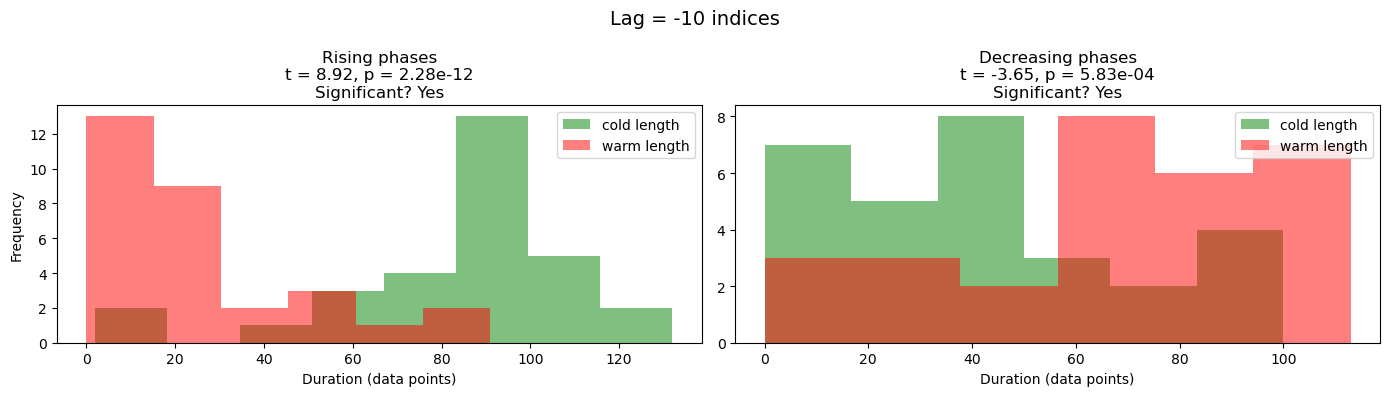

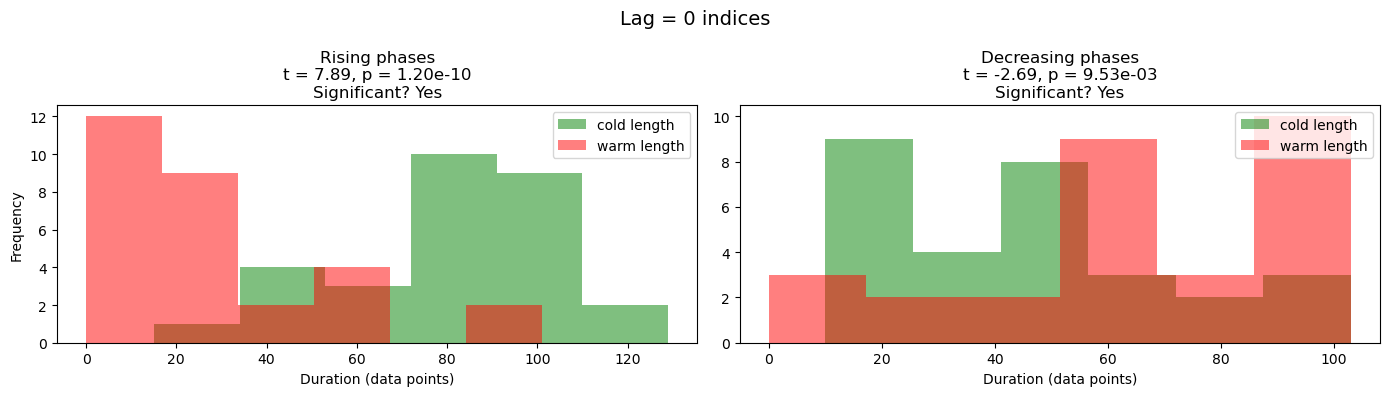

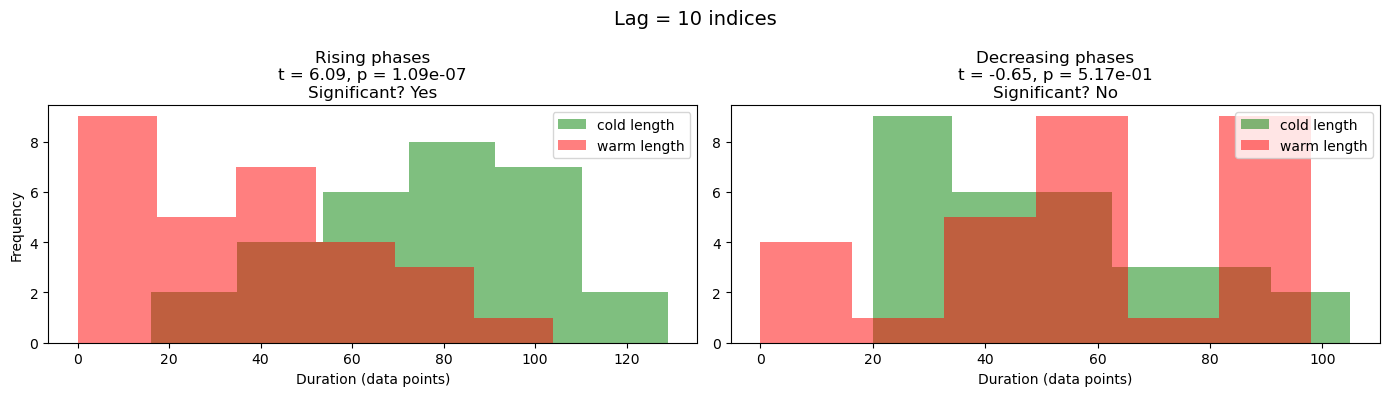

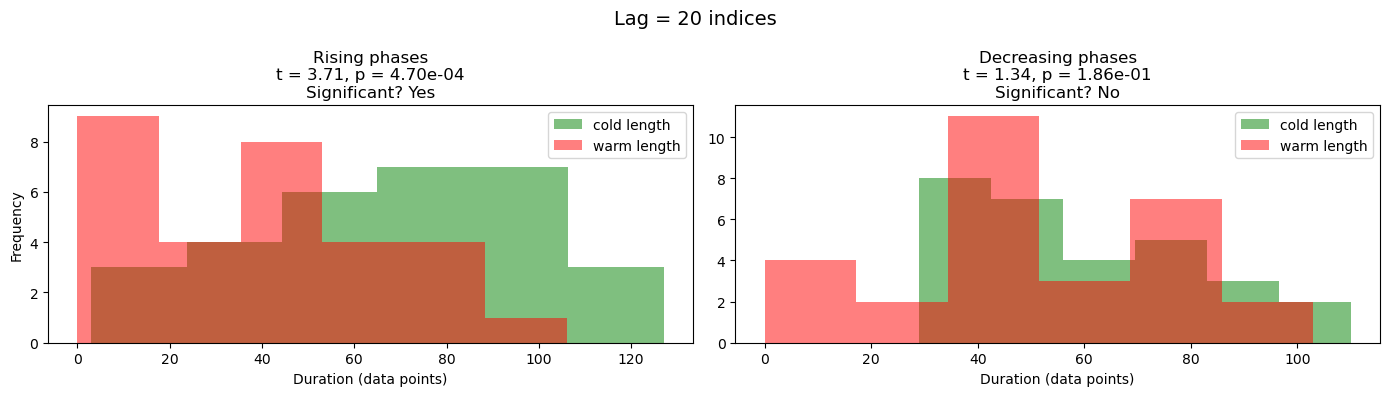

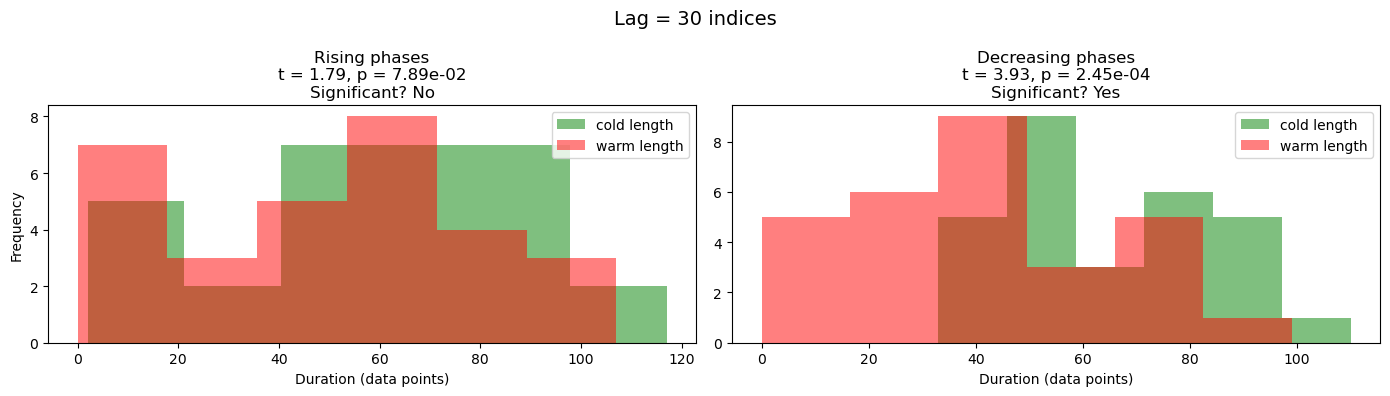

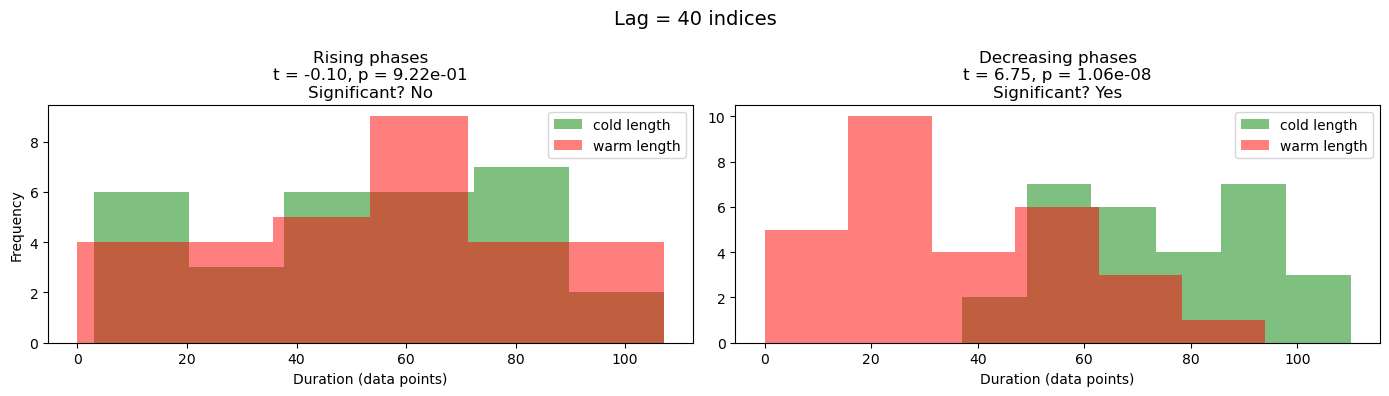

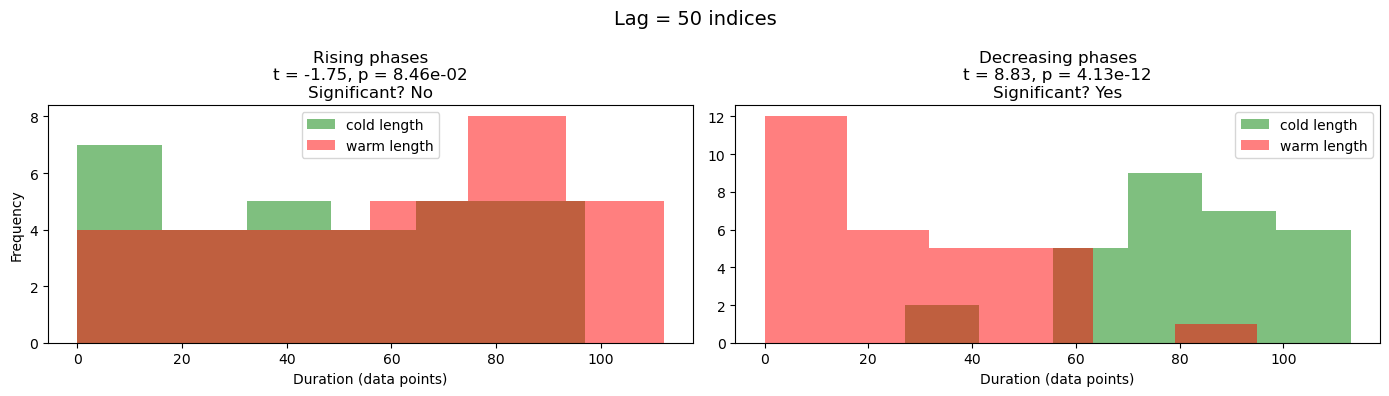

In [22]:
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# assume pre_vals_orig, sq_sign (±1 array), and count_transitions() exist...

for lag in range(-50, 51, 10):
    # 1) shift & detect peaks/troughs
    pre_shifted = np.roll(pre_vals_orig, -lag)
    peaks, _    = find_peaks(pre_shifted)
    troughs, _ = find_peaks(-pre_shifted)

    # 2) rising & falling intervals
    rising, falling = [], []
    for t in troughs:
        nxt = peaks[peaks > t]
        if nxt.size: rising.append((t, nxt[0]))
    for p in peaks:
        nxt = troughs[troughs > p]
        if nxt.size: falling.append((p, nxt[0]))

    # 3) compute durations for rising phases
    r_cold, r_warm = [], []
    for i0, i1 in rising:
        seg = sq_sign[i0:i1+1]
        r_cold.append(np.sum(seg == -1))
        r_warm.append(np.sum(seg == +1))

    # 4) compute durations for decreasing phases
    d_cold, d_warm = [], []
    for i0, i1 in falling:
        seg = sq_sign[i0:i1+1]
        d_cold.append(np.sum(seg == -1))
        d_warm.append(np.sum(seg == +1))

    # 5) t‐tests on durations
    t_r, p_r = ttest_ind(r_cold, r_warm, equal_var=False)
    sig_r = 'Yes' if p_r < 0.05 else 'No'
    t_d, p_d = ttest_ind(d_cold, d_warm, equal_var=False)
    sig_d = 'Yes' if p_d < 0.05 else 'No'

    # 6) plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), tight_layout=True)
    fig.suptitle(f"Lag = {lag} indices", fontsize=14)

    # Rising‐phase durations
    ax1.hist(r_cold, bins='auto', alpha=0.5, color='green', label='cold length')
    ax1.hist(r_warm, bins='auto', alpha=0.5, color='red',   label='warm length')
    ax1.set_title(
        f"Rising phases\n"
        f"t = {t_r:.2f}, p = {p_r:.2e}\n"
        f"Significant? {sig_r}"
    )
    ax1.set_xlabel('Duration (data points)')
    ax1.set_ylabel('Frequency')
    ax1.legend()

    # Decreasing‐phase durations
    ax2.hist(d_cold, bins='auto', alpha=0.5, color='green', label='cold length')
    ax2.hist(d_warm, bins='auto', alpha=0.5, color='red',   label='warm length')
    ax2.set_title(
        f"Decreasing phases\n"
        f"t = {t_d:.2f}, p = {p_d:.2e}\n"
        f"Significant? {sig_d}"
    )
    ax2.set_xlabel('Duration (data points)')
    ax2.legend()

    plt.show()


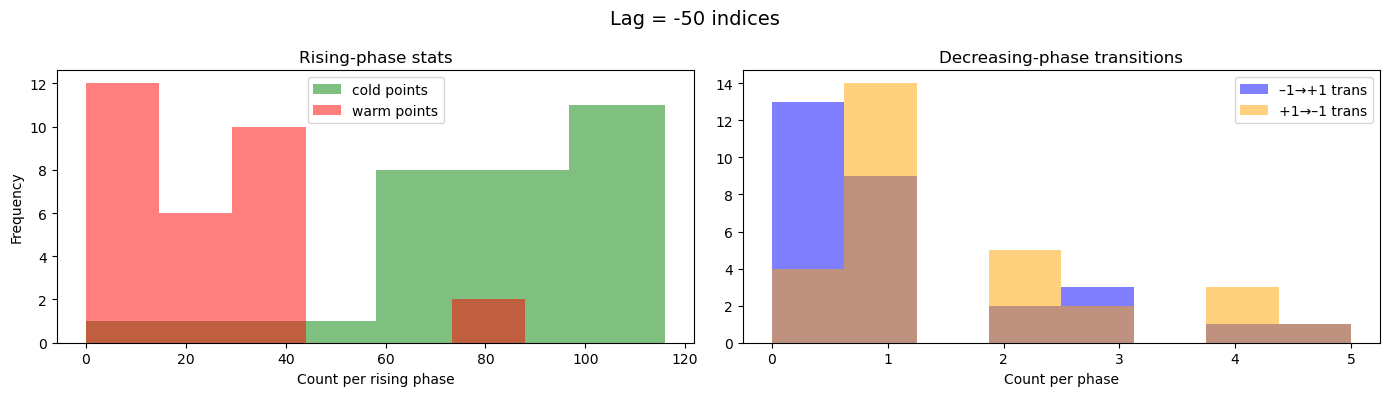

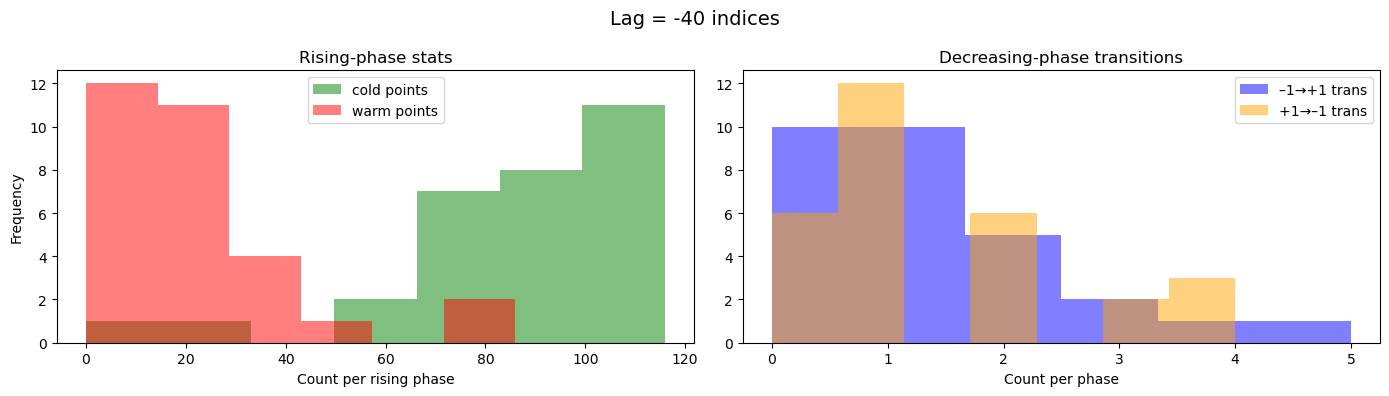

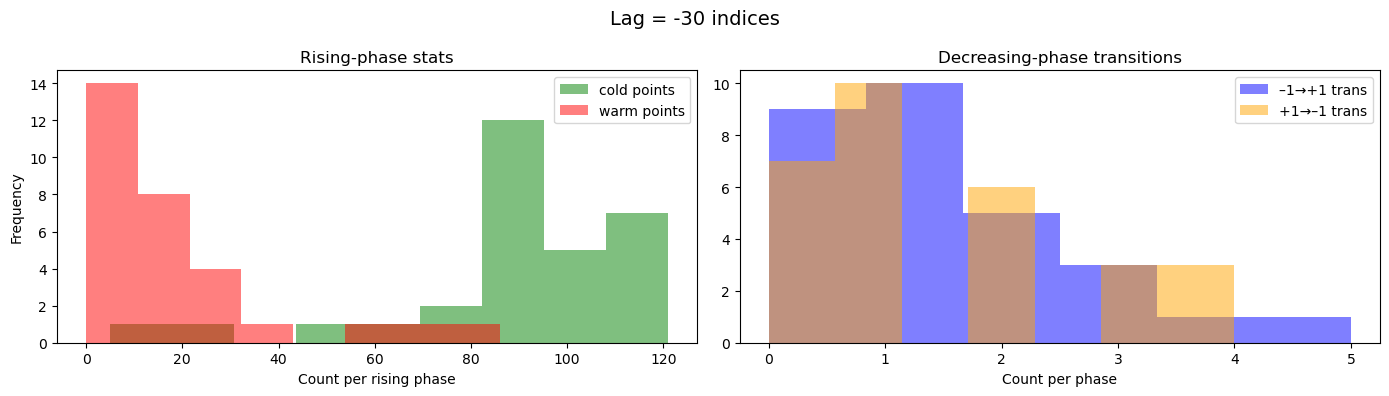

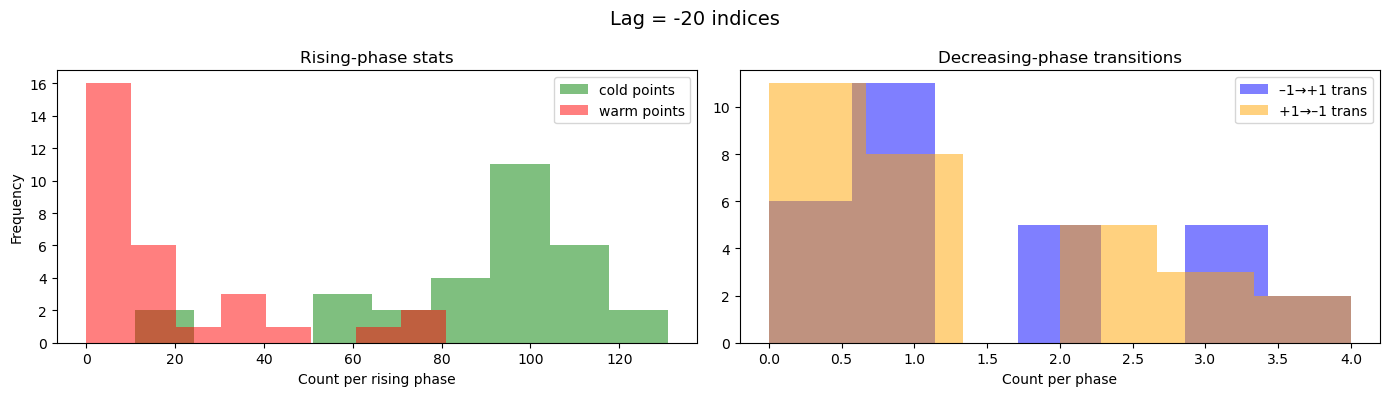

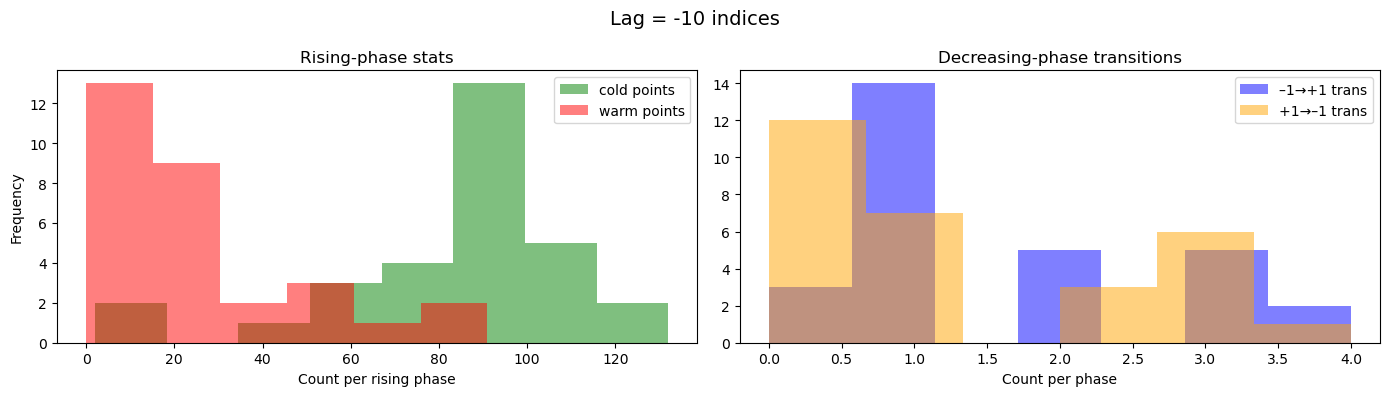

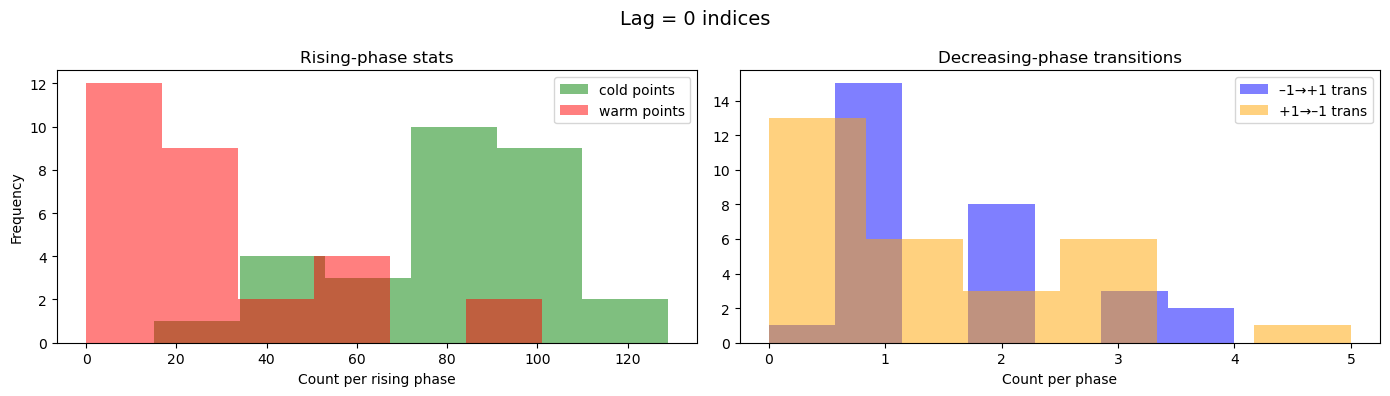

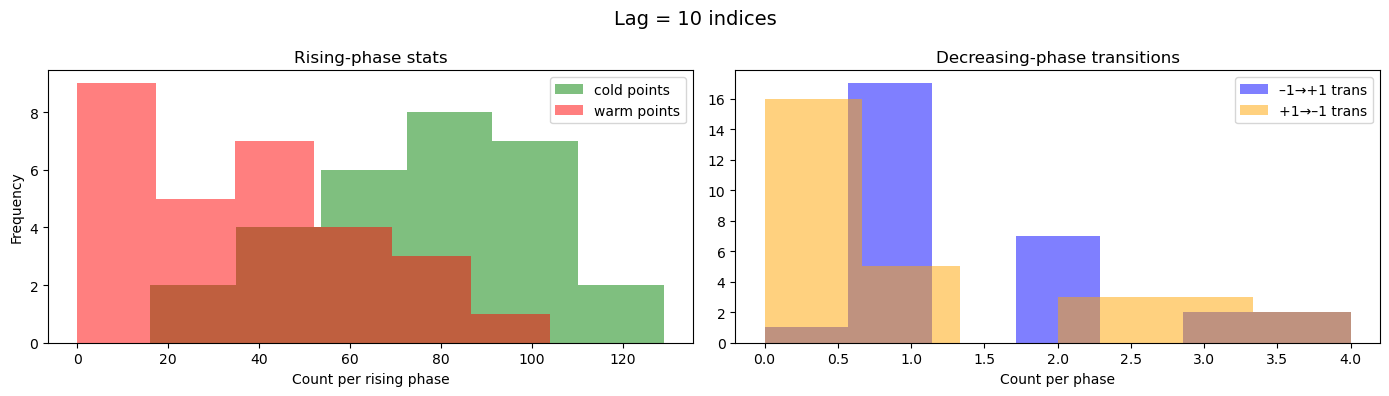

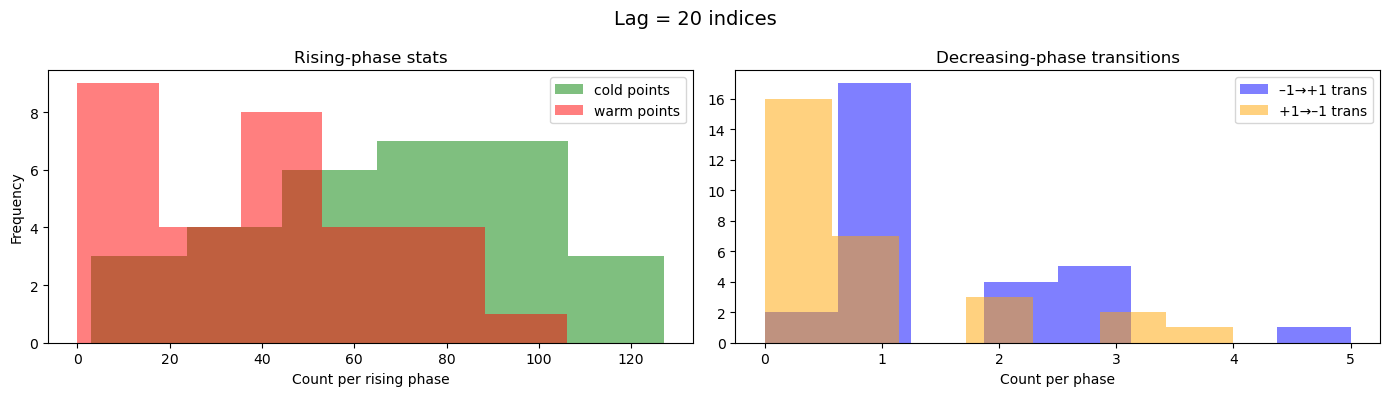

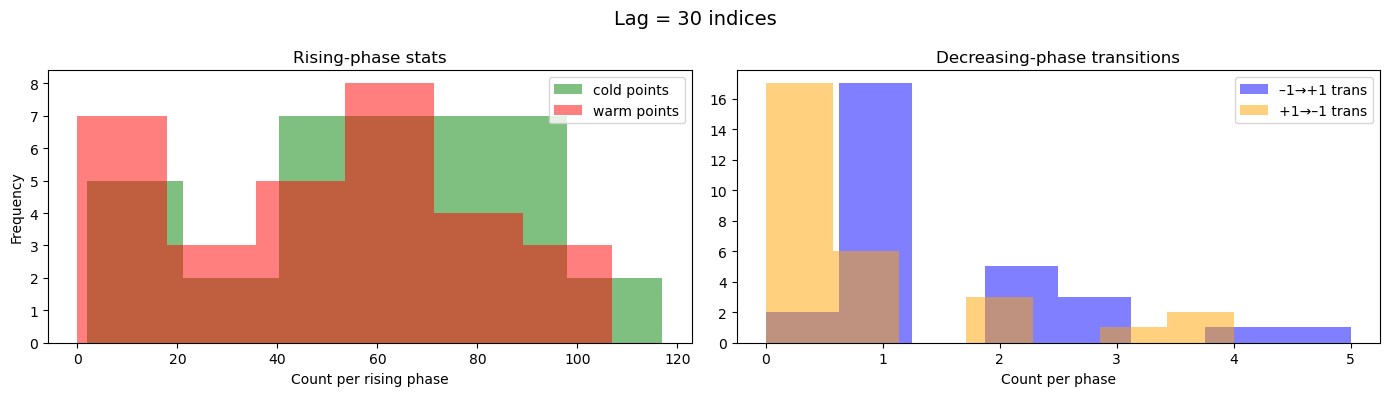

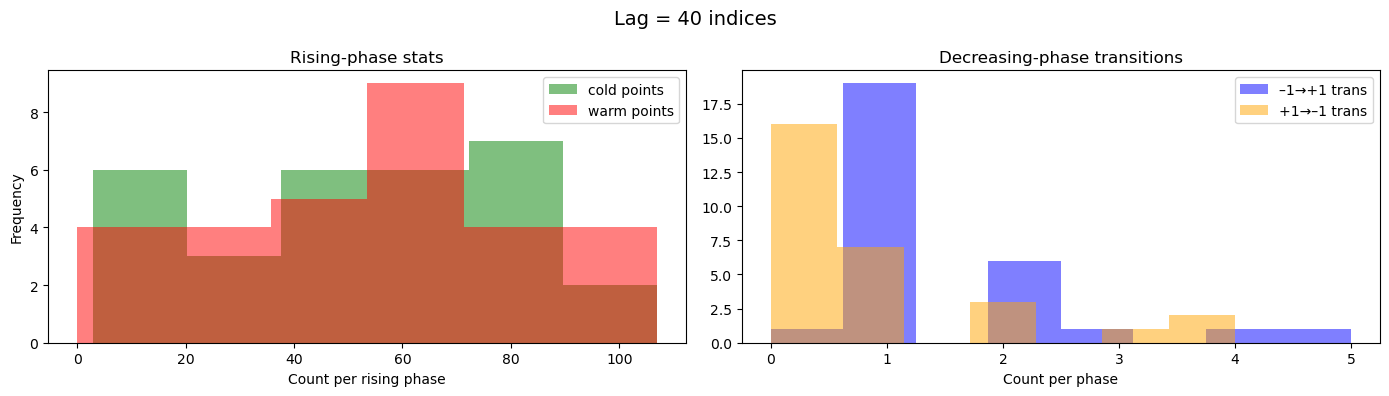

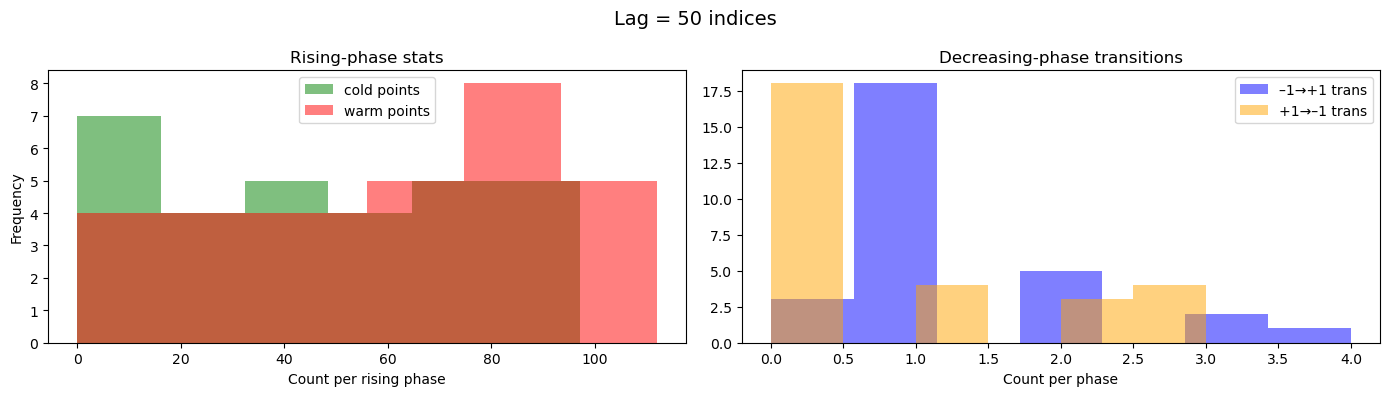

In [17]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# assume pre_vals_orig, sq_sign, and count_transitions() are defined as before...

for lag in range(-50, 51, 10):
    # 1) shift & detect peaks/troughs
    pre_shifted = np.roll(pre_vals_orig, -lag)
    peaks, _    = find_peaks(pre_shifted)
    troughs, _ = find_peaks(-pre_shifted)

    # 2) rising & falling intervals
    rising, falling = [], []
    for t in troughs:
        nxt = peaks[peaks > t]
        if nxt.size: rising.append((t, nxt[0]))
    for p in peaks:
        nxt = troughs[troughs > p]
        if nxt.size: falling.append((p, nxt[0]))

    # 3) count transitions
    r_lt, r_hl = count_transitions(rising, sq_sign)
    f_lt, f_hl = count_transitions(falling, sq_sign)

    # 4) now also compute cold/warm durations in each rising phase
    r_cold, r_warm = [], []
    for i0, i1 in rising:
        seg = sq_sign[i0:i1+1]
        r_cold.append(np.sum(seg == -1))
        r_warm.append(np.sum(seg == +1))

    # 5) plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), tight_layout=True)
    fig.suptitle(f"Lag = {lag} indices", fontsize=14)

    # rising panel: transitions + durations
    # ax1.hist(r_lt,   bins='auto', alpha=0.5, color='blue',   label='–1→+1 trans')
    # ax1.hist(r_hl,   bins='auto', alpha=0.5, color='orange', label='+1→–1 trans')
    ax1.hist(r_cold, bins='auto', alpha=0.5, color='green',  label='cold points')
    ax1.hist(r_warm, bins='auto', alpha=0.5, color='red',    label='warm points')
    ax1.set_title('Rising-phase stats')
    ax1.set_xlabel('Count per rising phase')
    ax1.set_ylabel('Frequency')
    ax1.legend()

    # falling panel: just transitions (as before)
    ax2.hist(f_lt, bins='auto', alpha=0.5, color='blue',   label='–1→+1 trans')
    ax2.hist(f_hl, bins='auto', alpha=0.5, color='orange', label='+1→–1 trans')
    ax2.set_title('Decreasing-phase transitions')
    ax2.set_xlabel('Count per phase')
    ax2.legend()

    plt.show()


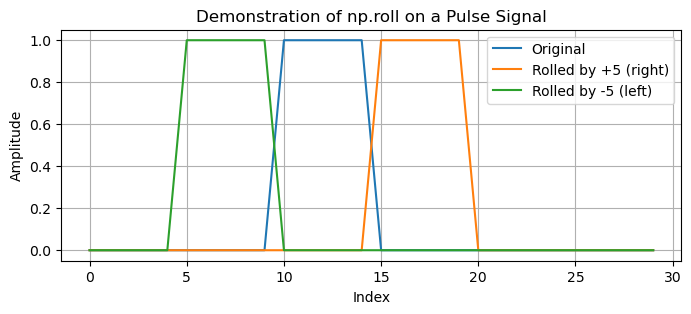

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple pulse signal
length = 30
pulse = np.zeros(length)
pulse[10:15] = 1  # a block of ones from index 10 to 14

# Apply np.roll shifts
rolled_right = np.roll(pulse, 5)   # shift right by 5
rolled_left  = np.roll(pulse, -5)  # shift left by 5

# Plot original and rolled pulse
plt.figure(figsize=(8, 3))
plt.plot(pulse, label='Original')
plt.plot(rolled_right, label='Rolled by +5 (right)')
plt.plot(rolled_left, label='Rolled by -5 (left)')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('Demonstration of np.roll on a Pulse Signal')
plt.legend()
plt.grid(True)
plt.show()


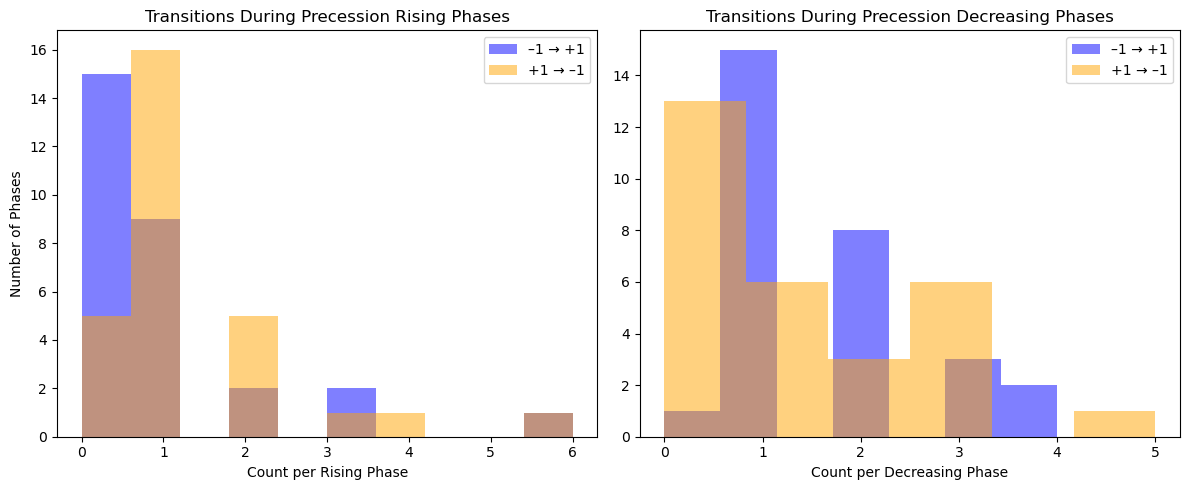

In [14]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# --- assume df_pre and df_sq already exist as before ---

# 1) find peaks & troughs
pre_vals     = df_pre['pre'].values
peaks_idx, _ = find_peaks(pre_vals)
troughs_idx,_ = find_peaks(-pre_vals)

# 2) rising intervals (trough → next peak)
rising_intervals = []
for t in troughs_idx:
    next_pk = peaks_idx[peaks_idx > t]
    if next_pk.size:
        rising_intervals.append((t, next_pk[0]))

# 3) decreasing intervals (peak → next trough)
decreasing_intervals = []
for p in peaks_idx:
    next_tr = troughs_idx[troughs_idx > p]
    if next_tr.size:
        decreasing_intervals.append((p, next_tr[0]))

# 4) discretize square wave back to ±1
sq_sign = np.where(df_sq['sq'].values > 0, 1, -1)

# 5) helper to count transitions in a list of (start,end) indices
def count_transitions(intervals):
    lt_counts, hl_counts = [], []
    for i0, i1 in intervals:
        seg = sq_sign[i0 : i1+1]
        lt = np.sum((seg[:-1]==-1) & (seg[1:]==+1))
        hl = np.sum((seg[:-1]==+1) & (seg[1:]==-1))
        lt_counts.append(lt)
        hl_counts.append(hl)
    return lt_counts, hl_counts

r_lt, r_hl = count_transitions(rising_intervals)
d_lt, d_hl = count_transitions(decreasing_intervals)

# 6) plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# rising
ax1.hist(r_lt, bins='auto', alpha=0.5, label='–1 → +1', color='blue')
ax1.hist(r_hl, bins='auto', alpha=0.5, label='+1 → –1', color='orange')
ax1.set_title('Transitions During Precession Rising Phases')
ax1.set_xlabel('Count per Rising Phase')
ax1.set_ylabel('Number of Phases')
ax1.legend()

# decreasing
ax2.hist(d_lt, bins='auto', alpha=0.5, label='–1 → +1', color='blue')
ax2.hist(d_hl, bins='auto', alpha=0.5, label='+1 → –1', color='orange')
ax2.set_title('Transitions During Precession Decreasing Phases')
ax2.set_xlabel('Count per Decreasing Phase')
ax2.legend()

plt.show()


<bound method NDFrame.head of               age   d18O
0        -16.5010 -9.500
1          0.0000 -9.660
2         19.9980 -9.580
3         38.2475 -9.500
4         56.4970 -9.330
...           ...    ...
8348  640277.6000 -8.855
8349  640520.9000 -9.140
8350  640766.5000 -9.059
8351  641014.4000 -9.343
8352  641264.4000 -9.338

[8353 rows x 2 columns]>
641264.4
-16.501


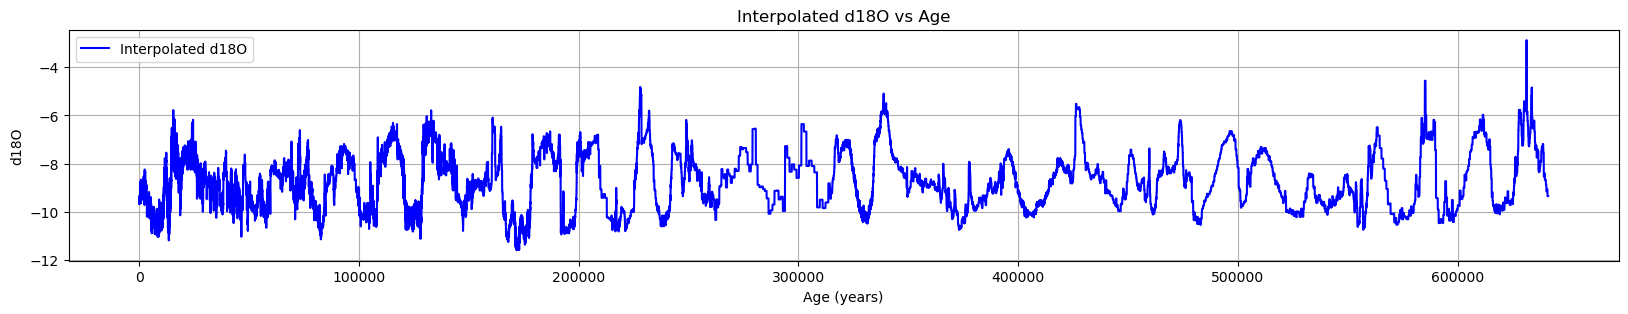

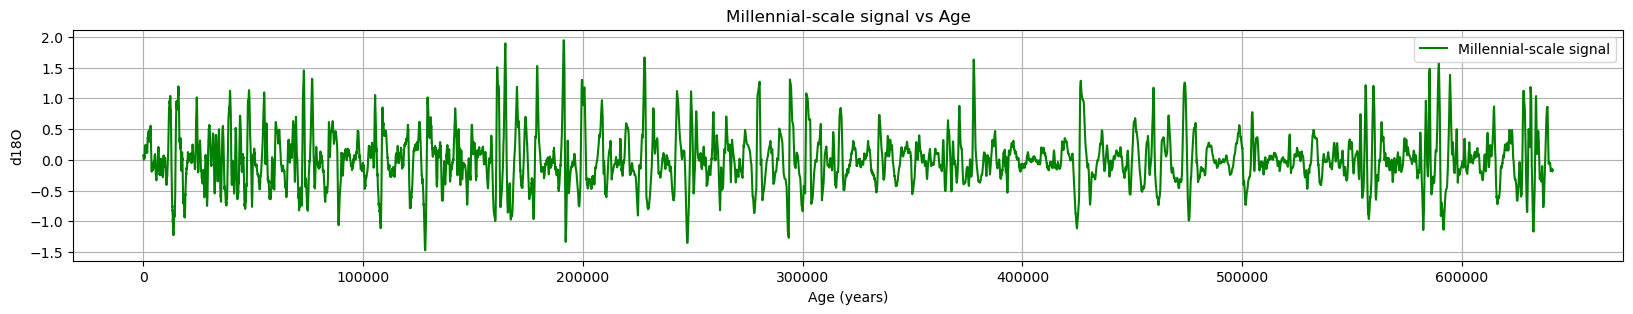

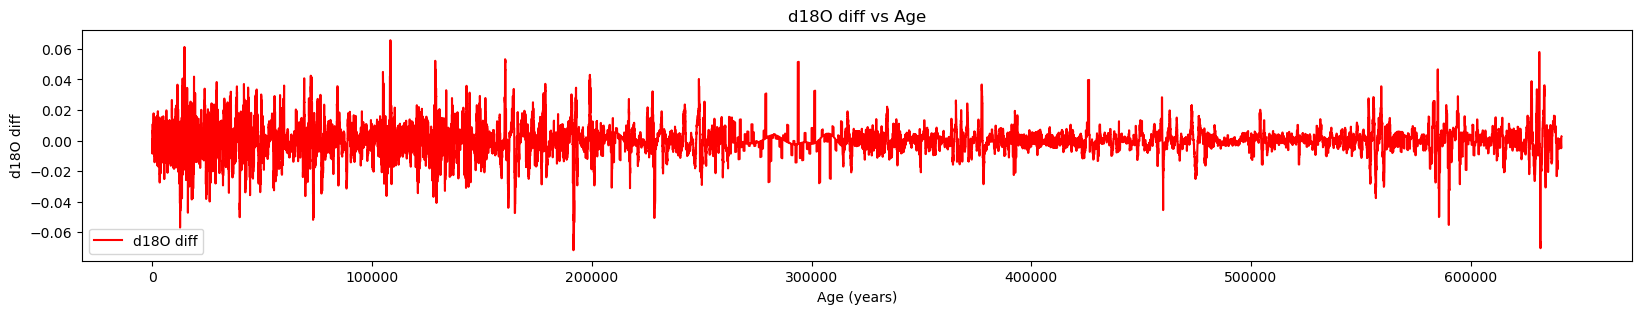

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# path to your file
file_path = r"D:\VScode\bipolar_seesaw_CCM\other_data\monsoon.xlsx"

# read the first sheet into a DataFrame
df = pd.read_excel(file_path)
# age =age *1000
df['age'] = df['age'] * 1000

print(df.head)
# print the age max and min
print(df['age'].max())
print(df['age'].min())
# resample the data from age 0 to 641260 with a step of 10
new_age = np.arange(0, 641260, 10)
# create a new DataFrame with the new age values
f = interp1d(df['age'], df['d18O'], kind='nearest',
             bounds_error=False,
             fill_value=1)            

interpolated_sq = f(new_age)

# create a new DataFrame with the new age values
new_df = pd.DataFrame({'age': new_age, 'd18O': interpolated_sq})
# plot the data
plt.figure(figsize=(20, 3))
plt.plot(new_df['age'], new_df['d18O'], label='Interpolated d18O', color='blue')
plt.xlabel('Age (years)')
plt.ylabel('d18O')
plt.title('Interpolated d18O vs Age')
plt.legend()
plt.grid()
plt.show()


new_df["smoothed"] = new_df["d18O"].rolling(window=1000, center=True, min_periods=1).mean()

# 3) Millennial‐scale signal = original minus low‐frequency
new_df["d18O"] = new_df["d18O"] - new_df["smoothed"]


# from scipy.signal import butter, filtfilt

# def butter_highpass(cutoff, fs, order=4):
#     nyq = 0.5 * fs
#     normal_cutoff = cutoff / nyq
#     b, a = butter(order, normal_cutoff, btype='high', analog=False)
#     return b, a
# # 2) Parameters
# dt = 10.0              # years between samples
# fs = 1.0 / dt          # sampling frequency [per year]
# cutoff = 1.0 / 10000.0 # desired cutoff [per year]
# order = 4

# # 3) Design filter
# b, a = butter_highpass(cutoff, fs, order=order)
# # 4) Apply filter (zero-phase) to the d18O column
# new_df['d18O'] = filtfilt(b, a, new_df['d18O'].values)



# smooth the millennial‐scale signal with a rolling mean 
new_df["d18O"] = new_df["d18O"].rolling(window=50, center=True, min_periods=1).mean()

# plot the smoothed data
plt.figure(figsize=(20, 3))
plt.plot(new_df['age'], new_df['d18O'], label='Millennial‐scale signal', color='green')
plt.xlabel('Age (years)')
plt.ylabel('d18O')
plt.title('Millennial‐scale signal vs Age')
plt.legend()
plt.grid()
plt.show()

# calculate the diff of d18O, and create a new DataFrame with the diff values
diff_d18O = np.diff(new_df['d18O'])
df_d18O_diff = pd.DataFrame({'age': new_df['age'].values[1:], 'd18O_diff': diff_d18O})

# plot the diff of d18O
plt.figure(figsize=(20, 3))
plt.plot(df_d18O_diff['age'], df_d18O_diff['d18O_diff'], label='d18O diff', color='red')
plt.xlabel('Age (years)')
plt.ylabel('d18O diff')
plt.title('d18O diff vs Age')
plt.legend()



Best threshold = gt -0.068,  F1 = 0.65


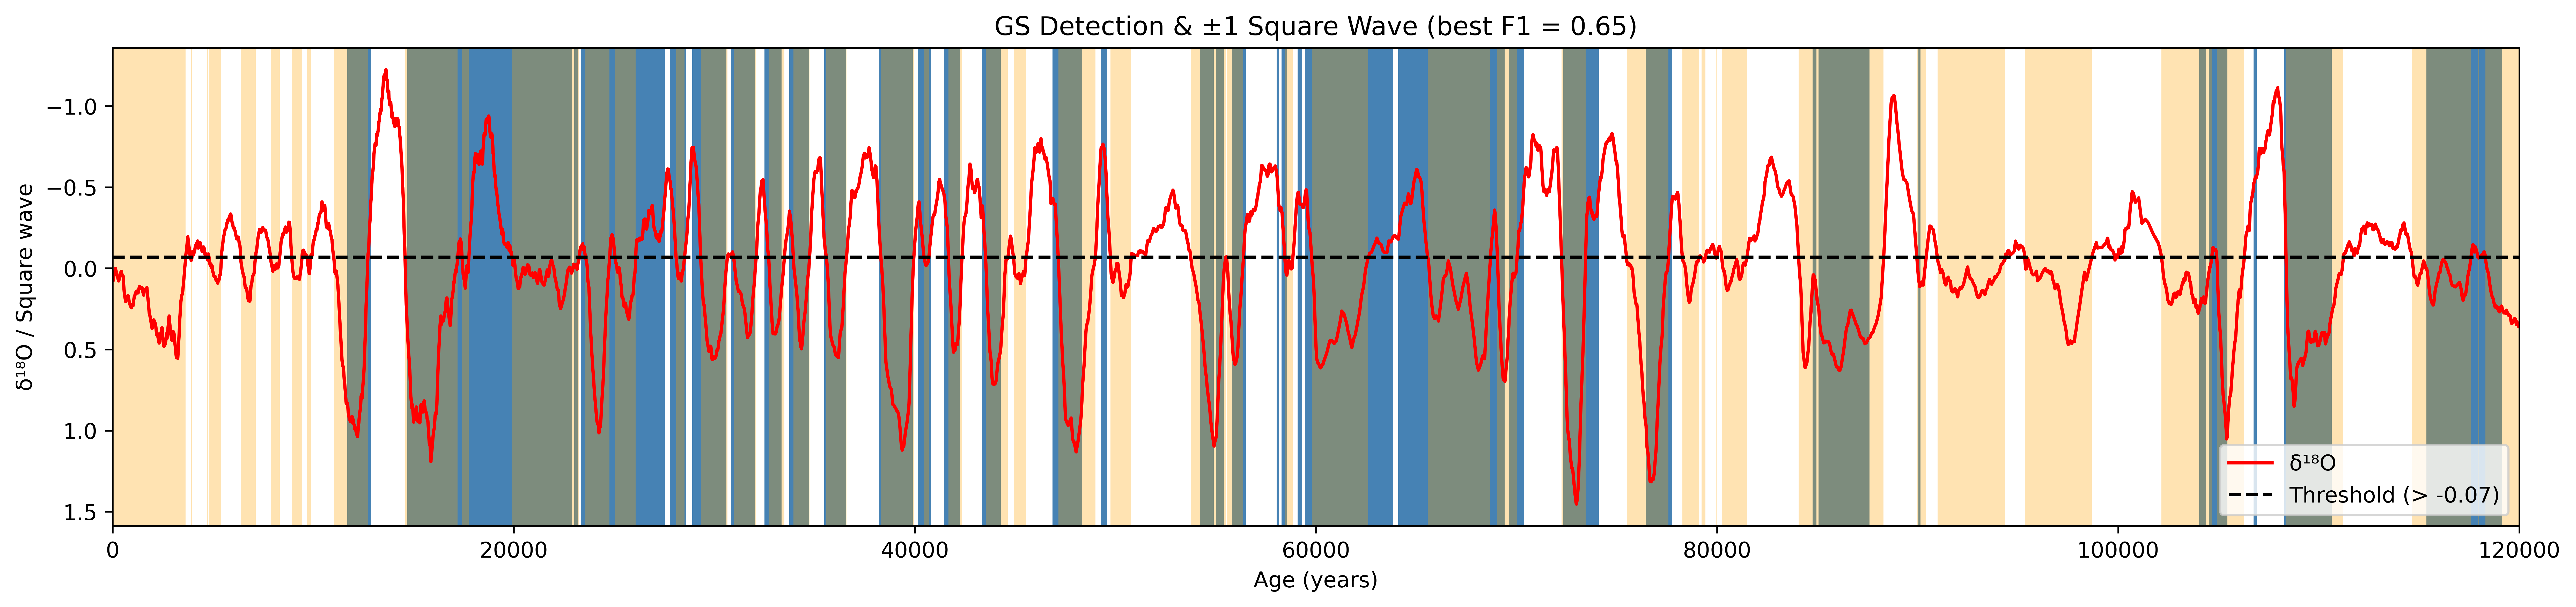

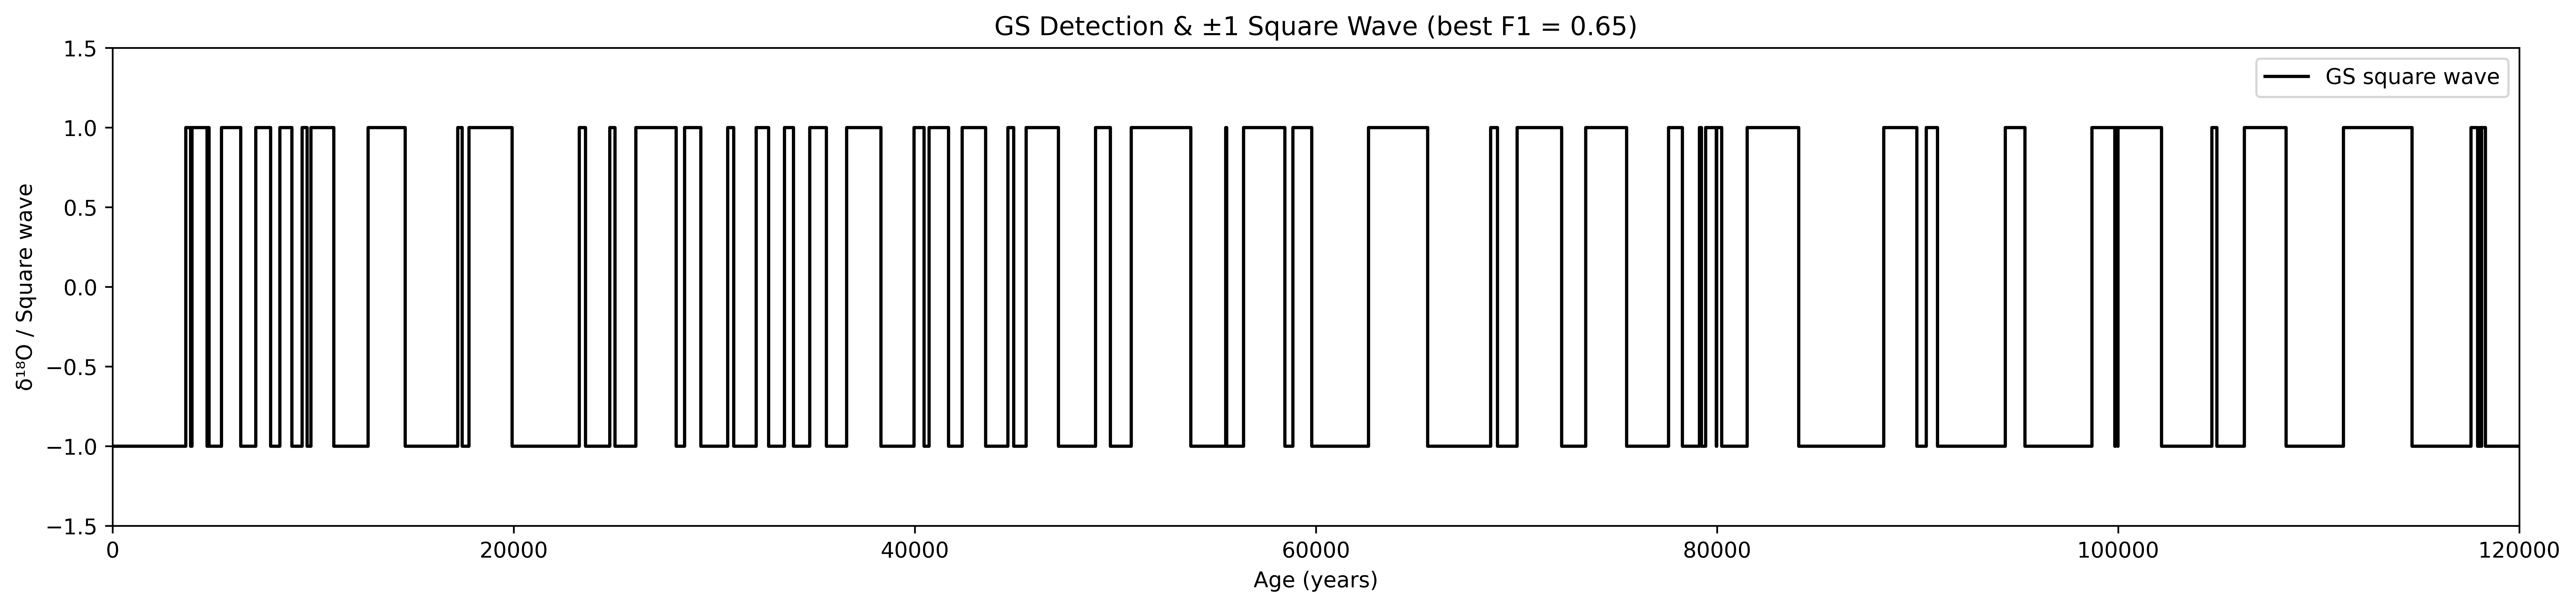

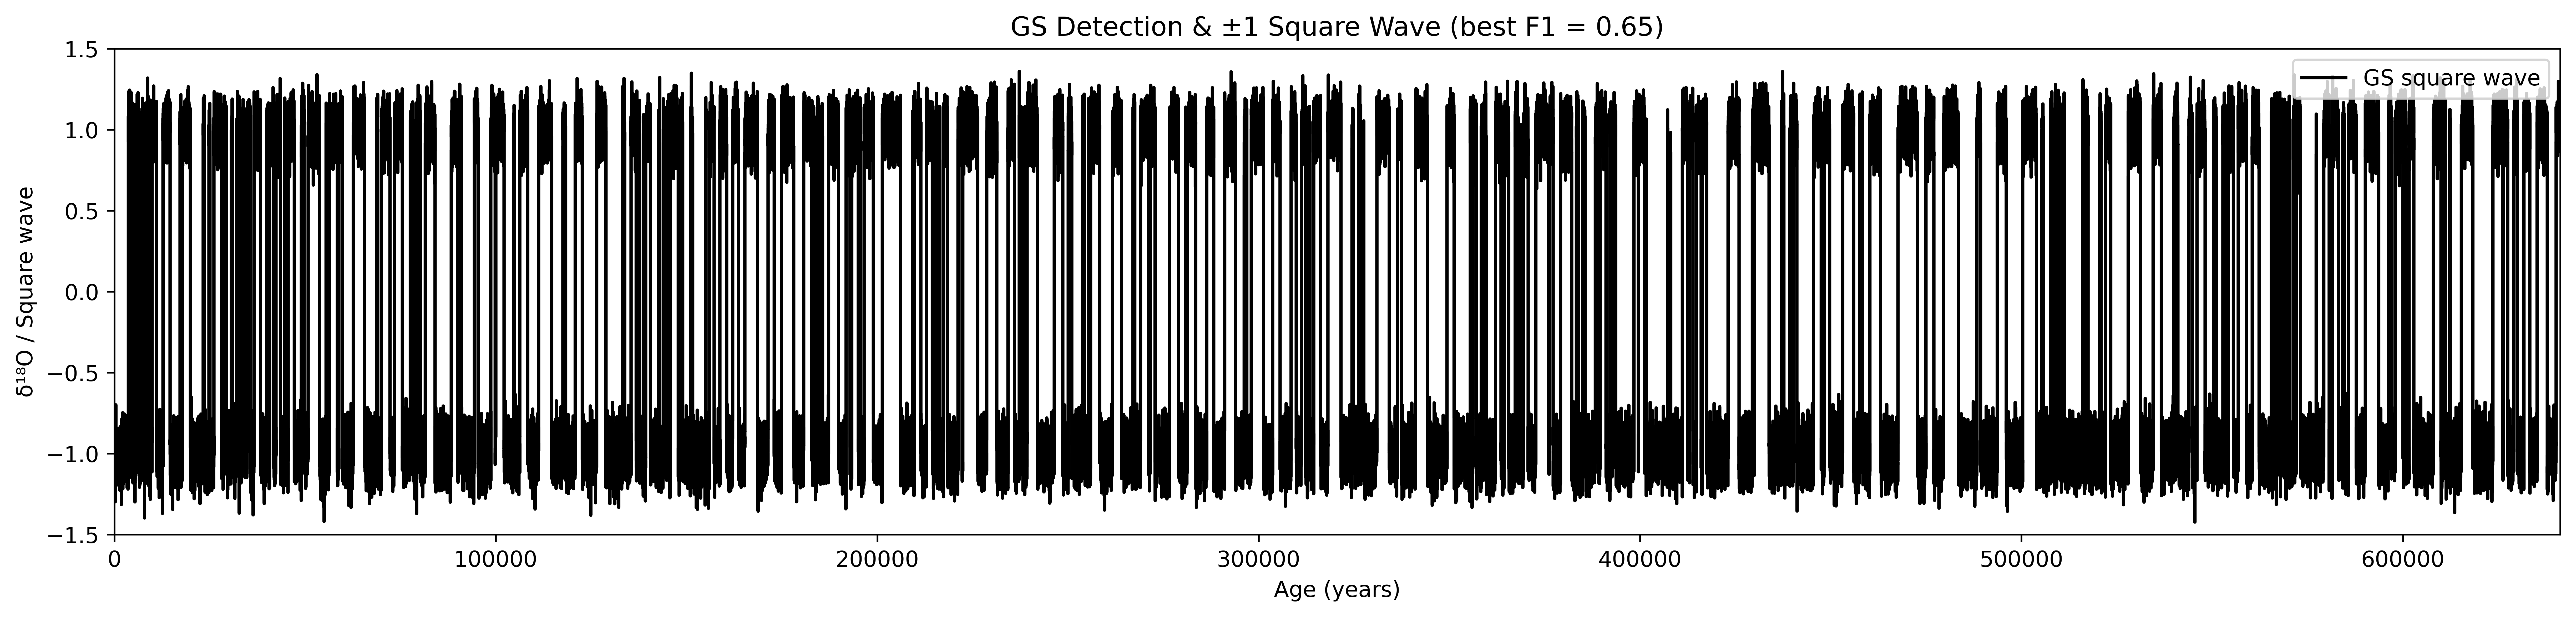

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby

# ------------------------------------------------------------------
# 1.  YOUR GS TABLE  (unchanged)
# ------------------------------------------------------------------
data = {
    "event": ["GS-1", "GS-2.1c", "GS-2.2", "GS-3", "GS-4", "GS-5.1", "GS-5.2", "GS-6",
              "GS-7", "GS-8", "GS-9", "GS-10", "GS-11", "GS-12", "GS-13", "GS-14",
              "GS-15.1", "GS-15.2", "GS-16.1", "GS-16.2", "GS-17.1", "GS-17.2",
              "GS-18", "GS-19.1", "GS-19.2", "GS-20", "GS-21.1", "GS-21.2", "GS-22",
              "GS-23.1", "GS-23.2", "GS-24.1", "GS-24.2", "GS-25", "GS-26"],
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040, 104520, 106750, 108280, 115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380, 105440, 106900, 110640, 119140]
}

# ------------------------------------------------------------------
# 2.  Boolean "ground-truth" vector
# ------------------------------------------------------------------
# crop the df for data <120000 years
new_df_crop = new_df.copy()
new_df_crop = new_df_crop[new_df_crop['age'] < 120000]

ages = new_df_crop['age'].values
d18O  = new_df_crop['d18O'].values

ages_all = new_df['age'].values
d18O_all  = new_df['d18O'].values

is_gs_true = np.zeros_like(ages, dtype=bool)
for s, e in zip(data["start"], data["end"]):
    is_gs_true |= (ages >= s) & (ages <= e)

# ------------------------------------------------------------------
# 3.  Find best δ18O threshold (as before)
# ------------------------------------------------------------------
def f1(pred, true):
    tp = np.sum(pred & true)
    fp = np.sum(pred & ~true)
    fn = np.sum(~pred & true)
    return 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) else 0

cands = np.percentile(d18O, np.linspace(5, 95, 181))
best_thr, best_f1, best_dir = None, -1, None
for direction in ('gt','lt'):
    for thr in cands:
        pred = d18O > thr if direction=='gt' else d18O < thr
        score = f1(pred, is_gs_true)
        if score > best_f1:
            best_thr, best_f1, best_dir = thr, score, direction

# ------------------------------------------------------------------
# 4.  Build predicted GS mask & contiguous segments
# ------------------------------------------------------------------

# is_gs_pred = d18O > best_thr if best_dir=='gt' else d18O < best_thr
is_gs_pred = d18O_all > best_thr if best_dir=='gt' else d18O_all < best_thr

segments = []
for k, grp in groupby(enumerate(is_gs_pred), key=lambda x:x[1]):
    if k:
        grp = list(grp)
        segments.append((ages_all[grp[0][0]], ages_all[grp[-1][0]]))

print(f"Best threshold = {best_dir} {best_thr:.3f},  F1 = {best_f1:.2f}")

# ------------------------------------------------------------------
# 5.  Create the ±1 square wave: -1 inside GS, +1 outside
# ------------------------------------------------------------------
square_wave = np.where(is_gs_pred, -1, 1)

# ------------------------------------------------------------------
# 6.  Plot everything
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(20, 4), dpi=600)

# a) Official GS intervals
for s, e in zip(data["start"], data["end"]):
    ax.axvspan(s, e, color='steelblue', alpha=1, zorder=0, linewidth=0)

# b) Predicted GS intervals
for s, e in segments:
    ax.axvspan(s, e, color='orange', alpha=0.30, zorder=1, linewidth=0)

# c) δ18O curve
ax.plot(ages, d18O, color='red', label='δ¹⁸O', zorder=2)

# d) Horizontal threshold
ax.axhline(best_thr, color='k', linestyle='--',
           label=f"Threshold ({'>' if best_dir=='gt' else '<'} {best_thr:.2f})",
           zorder=3)

# # e) Square wave
# ax.plot(ages, square_wave, drawstyle='steps-post',
#         color='black', linewidth=1.5, label='GS square wave', zorder=4)

# # adjust y-limits so the square wave is clear
# ax.set_ylim(min(square_wave)-0.5, max(square_wave)+0.5)
# inverse the y-axis
ax.invert_yaxis()
# Cosmetics
ax.set_xlabel('Age (years)')
ax.set_ylabel('δ¹⁸O / Square wave')
ax.set_xlim(0, 120000)
ax.set_title(f"GS Detection & ±1 Square Wave (best F1 = {best_f1:.2f})")
# ax.grid(True)
ax.legend(loc='lower right')

plt.show()




fig, ax = plt.subplots(figsize=(20, 4), dpi=600)

# e) Square wave
ax.plot(ages_all, square_wave, drawstyle='steps-post',
        color='black', linewidth=1.5, label='GS square wave', zorder=4)

# adjust y-limits so the square wave is clear
ax.set_ylim(min(square_wave)-0.5, max(square_wave)+0.5)

# Cosmetics
ax.set_xlabel('Age (years)')
ax.set_ylabel('δ¹⁸O / Square wave')
ax.set_xlim(0, 120000)
ax.set_title(f"GS Detection & ±1 Square Wave (best F1 = {best_f1:.2f})")
# ax.grid(True)
ax.legend()

plt.show()






# create a new DataFrame for the square wave
df_sq = pd.DataFrame({'age': ages_all, 'sq': square_wave})

white_noise = np.random.normal(0, 0.1, len(square_wave))
df_sq['sq'] = df_sq['sq'] + white_noise




fig, ax = plt.subplots(figsize=(20, 4), dpi=600)
# e) Square wave
ax.plot(df_sq['age'], df_sq['sq'], drawstyle='steps-post',
        color='black', linewidth=1.5, label='GS square wave', zorder=4)

# adjust y-limits so the square wave is clear
ax.set_ylim(min(square_wave)-0.5, max(square_wave)+0.5)

# Cosmetics
ax.set_xlabel('Age (years)')
ax.set_ylabel('δ¹⁸O / Square wave')
# ax.set_xlim(0, 120000)
ax.set_title(f"GS Detection & ±1 Square Wave (best F1 = {best_f1:.2f})")
# ax.grid(True)
ax.legend(loc='upper right')
# set x lim
ax.set_xlim(0, 641260)

plt.show()



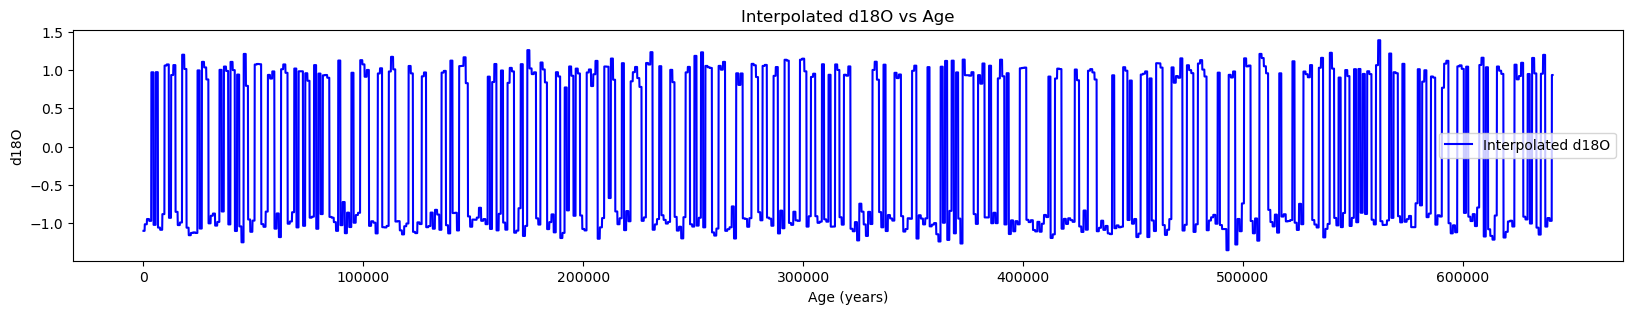

         age       pre
0          0  0.016280
1        100  0.016431
2        200  0.016568
3        300  0.016690
4        400  0.016798
...      ...       ...
6405  640500 -0.003302
6406  640600 -0.003582
6407  640700 -0.003858
6408  640800 -0.004129
6409  640900 -0.004396

[6410 rows x 2 columns]


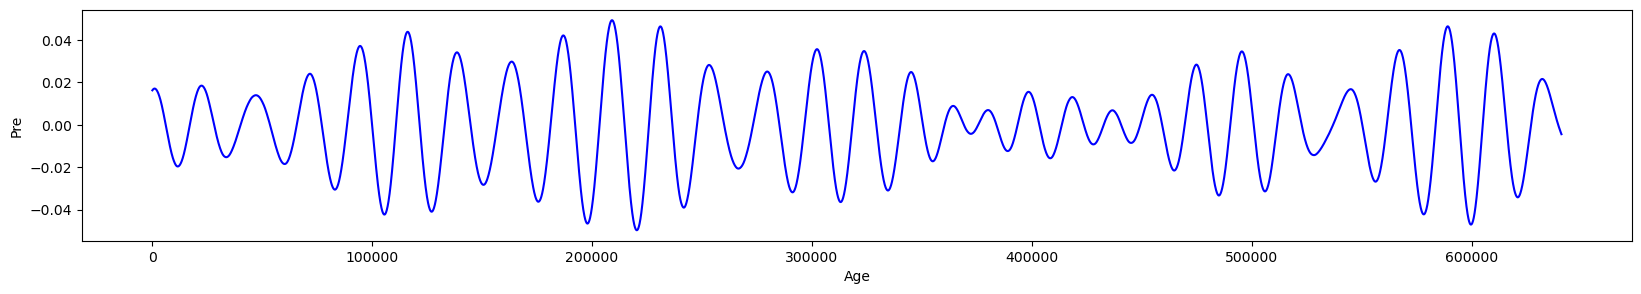

         age       obl
0          0  0.409093
1        100  0.409320
2        200  0.409547
3        300  0.409773
4        400  0.410000
...      ...       ...
6405  640500  0.398998
6406  640600  0.399029
6407  640700  0.399062
6408  640800  0.399098
6409  640900  0.399136

[6410 rows x 2 columns]


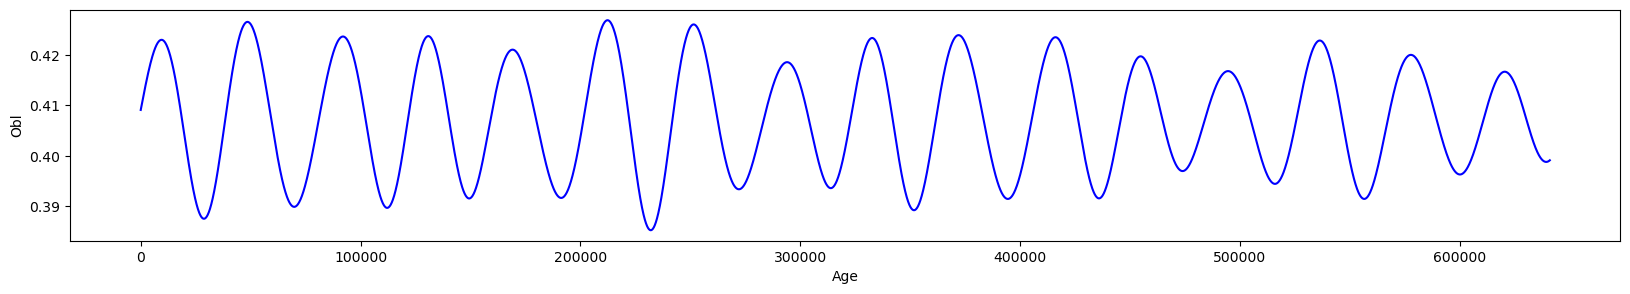

In [50]:
import pandas as pd
from scipy.interpolate import interp1d

# for df_sq, interpolated it to has 100 times lower resolution
new_age = np.arange(np.min(df_sq['age'].values), np.max(df_sq['age'].values), 100)
# create a new DataFrame with the new age values
f_sq = interp1d(df_sq['age'], df_sq['sq'], kind='nearest',
             bounds_error=False,
             fill_value=1)
interpolated_sq = f_sq(new_age)
# create a new DataFrame with the new age values
df_sq = pd.DataFrame({'age': new_age, 'sq': interpolated_sq})

# plot the data
plt.figure(figsize=(20, 3))
plt.plot(df_sq['age'], df_sq['sq'], label='Interpolated d18O', color='blue')
plt.xlabel('Age (years)')
plt.ylabel('d18O')
plt.title('Interpolated d18O vs Age')
plt.legend()
plt.show()

# # filp the second column upside down (last row to first row)
# df_sq['sq'] = df_sq['sq'].iloc[::-1].reset_index(drop=True)
# # plot the data
# plt.figure(figsize=(20, 3))
# plt.plot(df_sq['age'], df_sq['sq'], label='Interpolated d18O', color='blue')
# plt.xlabel('Age (years)')
# plt.ylabel('d18O')
# plt.title('Interpolated d18O vs Age')
# plt.legend()
# plt.show()




# Read the file into a DataFrame
df_pre = pd.read_csv(
    r"D:\VScode\bipolar_seesaw_CCM\inso_data\pre_800_inter100.txt", 
    sep='\s+',       # '\s+' means "split on any whitespace"
    header=None,     # or specify a row number if there's a header
    engine='python'
)

df_obl = pd.read_csv(
    r"D:\VScode\bipolar_seesaw_CCM\inso_data\obl_800_inter100.txt", 
    sep='\s+',       # '\s+' means "split on any whitespace"
    header=None,     # or specify a row number if there's a header
    engine='python'
)

df_pre.iloc[:, 0] = df_pre.iloc[:, 0].abs() * 1000
df_obl.iloc[:, 0] = df_obl.iloc[:, 0].abs() * 1000


# # plot df_pre
# plt.figure(figsize=(20, 3))
# plt.plot(df_pre.iloc[:, 0], df_pre.iloc[:, 1], label='pre', color='blue')
# plt.xlabel("Age")
# plt.ylabel("Pre")
# print(df_pre)
# plt.show()

# Reverse the DataFrame rows
df_pre = df_pre.iloc[::-1]
df_pre.columns = ['age', 'pre']

df_obl = df_obl.iloc[::-1]
df_obl.columns = ['age', 'obl']


# interpolate the data using new_age
f = interp1d(df_pre['age'], df_pre['pre'], kind='nearest',
             bounds_error=False,
             fill_value=1)

interpolated_pre = f(new_age)
df_pre = pd.DataFrame({'age': new_age, 'pre': interpolated_pre})

f = interp1d(df_obl['age'], df_obl['obl'], kind='nearest',
             bounds_error=False,
             fill_value=1)

interpolated_obl = f(new_age)
df_obl = pd.DataFrame({'age': new_age, 'obl': interpolated_obl})

# plot df_pre
plt.figure(figsize=(20, 3))
plt.plot(df_pre.iloc[:, 0], df_pre.iloc[:, 1], label='pre', color='blue')
plt.xlabel("Age")
plt.ylabel("Pre")
print(df_pre)
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(df_obl.iloc[:, 0], df_obl.iloc[:, 1], label='obl', color='blue')
plt.xlabel("Age")
plt.ylabel("Obl")
print(df_obl)
plt.show()

TE(pre→residual) = 0.0095 bits


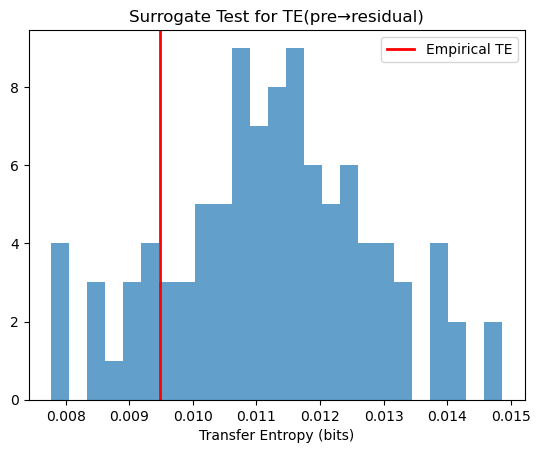

p-value = 0.850


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy  # correct import! :contentReference[oaicite:0]{index=0}

# — assume df_pre_aligned['pre'] and df_residual['residual'] exist and are same length
x = df_pre['pre'].values      # source (precession)
y = df_sq['sq'].values    # target (residual)

# 1) Discretize into nbins equiprobable bins
nbins = 8
xbins = np.histogram_bin_edges(x, bins=nbins)
ybins = np.histogram_bin_edges(y, bins=nbins)
x_disc = np.digitize(x, xbins) - 1
y_disc = np.digitize(y, ybins) - 1

# 2) Compute TE from pre→residual with history length k=1
#    note: drop last/first sample to align t→t+1
te_xy = transfer_entropy(x_disc[:-1], y_disc[1:], k=1)
print(f"TE(pre→residual) = {te_xy:.4f} bits")

# 3) Permutation‐based surrogate test
n_surr = 100
te_null = np.zeros(n_surr)
for i in range(n_surr):
    xs = np.random.permutation(x_disc)
    te_null[i] = transfer_entropy(xs[:-1], y_disc[1:], k=1)

# 4) Plot null distribution
plt.hist(te_null, bins=25, alpha=0.7)
plt.axvline(te_xy, color='r', lw=2, label='Empirical TE')
plt.xlabel('Transfer Entropy (bits)')
plt.legend()
plt.title('Surrogate Test for TE(pre→residual)')
plt.show()

# 5) Compute p-value
p_value = np.mean(te_null >= te_xy)
print(f"p-value = {p_value:.3f}")

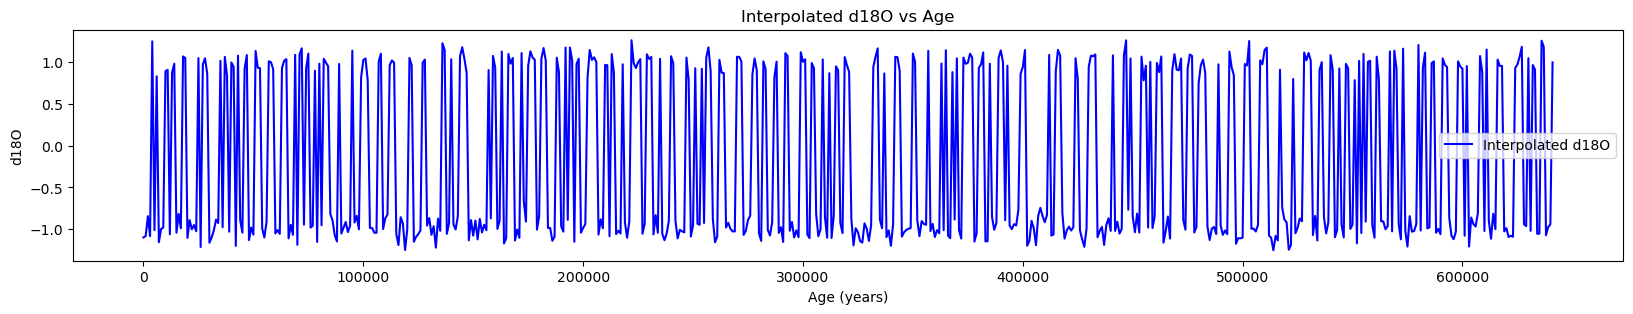

        age       pre
0         0  0.016280
1      1000  0.017116
2      2000  0.016308
3      3000  0.014018
4      4000  0.010453
..      ...       ...
637  637000  0.008929
638  638000  0.005100
639  639000  0.001432
640  640000 -0.001830
641  641000 -0.004658

[642 rows x 2 columns]


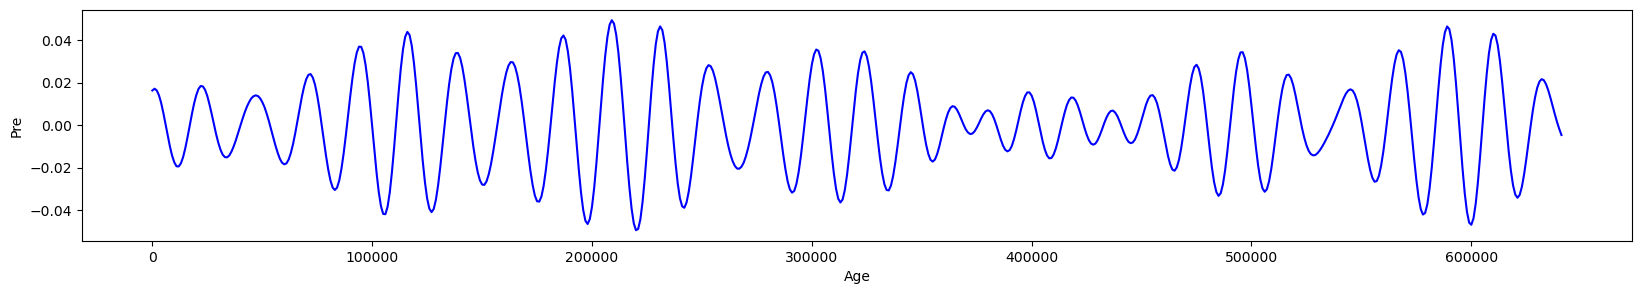

        age       obl
0         0  0.409093
1      1000  0.411353
2      2000  0.413555
3      3000  0.415639
4      4000  0.417555
..      ...       ...
637  637000  0.399430
638  638000  0.399004
639  639000  0.398819
640  640000  0.398878
641  641000  0.399176

[642 rows x 2 columns]


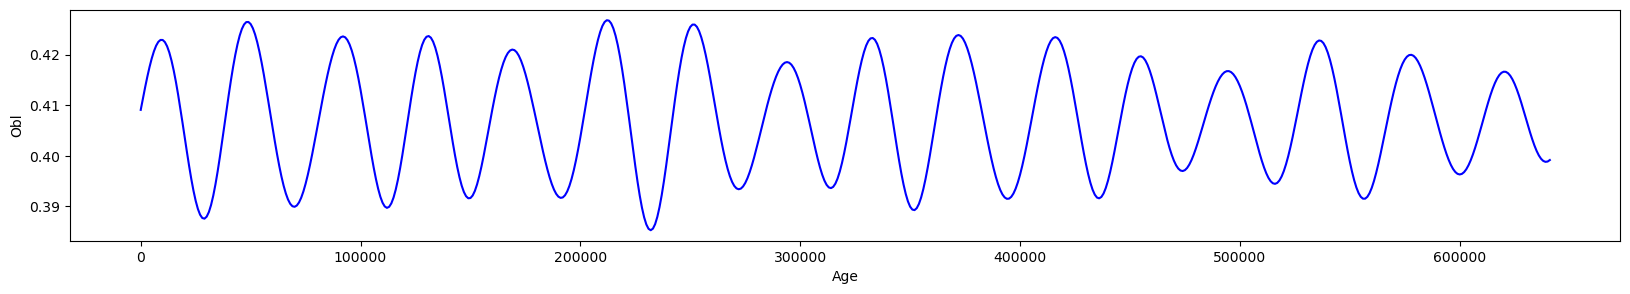

In [56]:
import pandas as pd
from scipy.interpolate import interp1d

# for df_sq, interpolated it to has 100 times lower resolution
new_age = np.arange(np.min(df_sq['age'].values), np.max(df_sq['age'].values), 1000)
# create a new DataFrame with the new age values
f_sq = interp1d(df_sq['age'], df_sq['sq'], kind='nearest',
             bounds_error=False,
             fill_value=1)
interpolated_sq = f_sq(new_age)
# create a new DataFrame with the new age values
df_sq = pd.DataFrame({'age': new_age, 'sq': interpolated_sq})

# plot the data
plt.figure(figsize=(20, 3))
plt.plot(df_sq['age'], df_sq['sq'], label='Interpolated d18O', color='blue')
plt.xlabel('Age (years)')
plt.ylabel('d18O')
plt.title('Interpolated d18O vs Age')
plt.legend()
plt.show()

# # filp the second column upside down (last row to first row)
# df_sq['sq'] = df_sq['sq'].iloc[::-1].reset_index(drop=True)
# # plot the data
# plt.figure(figsize=(20, 3))
# plt.plot(df_sq['age'], df_sq['sq'], label='Interpolated d18O', color='blue')
# plt.xlabel('Age (years)')
# plt.ylabel('d18O')
# plt.title('Interpolated d18O vs Age')
# plt.legend()
# plt.show()




# Read the file into a DataFrame
df_pre = pd.read_csv(
    r"D:\VScode\bipolar_seesaw_CCM\inso_data\pre_800.txt", 
    sep='\s+',       # '\s+' means "split on any whitespace"
    header=None,     # or specify a row number if there's a header
    engine='python'
)

df_obl = pd.read_csv(
    r"D:\VScode\bipolar_seesaw_CCM\inso_data\obl_800.txt", 
    sep='\s+',       # '\s+' means "split on any whitespace"
    header=None,     # or specify a row number if there's a header
    engine='python'
)

df_pre.iloc[:, 0] = df_pre.iloc[:, 0].abs() * 1000
df_obl.iloc[:, 0] = df_obl.iloc[:, 0].abs() * 1000


# # plot df_pre
# plt.figure(figsize=(20, 3))
# plt.plot(df_pre.iloc[:, 0], df_pre.iloc[:, 1], label='pre', color='blue')
# plt.xlabel("Age")
# plt.ylabel("Pre")
# print(df_pre)
# plt.show()

# Reverse the DataFrame rows
df_pre = df_pre.iloc[::-1]
df_pre.columns = ['age', 'pre']

df_obl = df_obl.iloc[::-1]
df_obl.columns = ['age', 'obl']


# interpolate the data using new_age
f = interp1d(df_pre['age'], df_pre['pre'], kind='nearest',
             bounds_error=False,
             fill_value=1)

interpolated_pre = f(new_age)
df_pre = pd.DataFrame({'age': new_age, 'pre': interpolated_pre})

f = interp1d(df_obl['age'], df_obl['obl'], kind='nearest',
             bounds_error=False,
             fill_value=1)

interpolated_obl = f(new_age)
df_obl = pd.DataFrame({'age': new_age, 'obl': interpolated_obl})

# plot df_pre
plt.figure(figsize=(20, 3))
plt.plot(df_pre.iloc[:, 0], df_pre.iloc[:, 1], label='pre', color='blue')
plt.xlabel("Age")
plt.ylabel("Pre")
print(df_pre)
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(df_obl.iloc[:, 0], df_obl.iloc[:, 1], label='obl', color='blue')
plt.xlabel("Age")
plt.ylabel("Obl")
print(df_obl)
plt.show()

In [15]:
df_sq.info

<bound method DataFrame.info of         age        sq
0         0 -0.798224
1      1000 -0.919420
2      2000 -1.072063
3      3000 -1.089792
4      4000 -0.976345
..      ...       ...
636  636000  0.852289
637  637000  0.811075
638  638000 -0.972099
639  639000 -0.888085
640  640000  0.993051

[641 rows x 2 columns]>

In [16]:
df_pre.info

<bound method DataFrame.info of         age       pre
0         0  0.016280
1      1000  0.017116
2      2000  0.016308
3      3000  0.014018
4      4000  0.010453
..      ...       ...
636  636000  0.012790
637  637000  0.008929
638  638000  0.005100
639  639000  0.001432
640  640000 -0.001830

[641 rows x 2 columns]>

TE(pre→residual) = 0.1013 bits


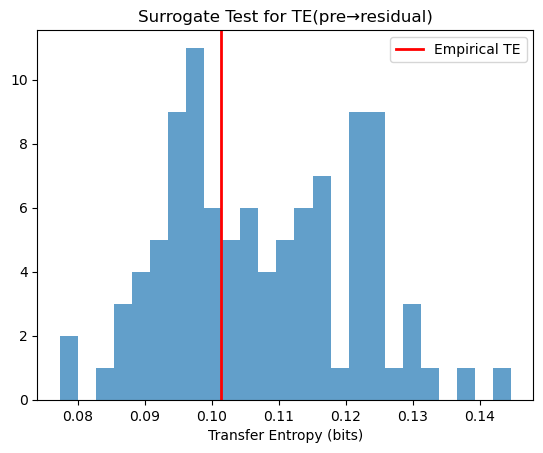

p-value = 0.600


In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy  # correct import! :contentReference[oaicite:0]{index=0}

# — assume df_pre_aligned['pre'] and df_residual['residual'] exist and are same length
x = df_pre['pre'].values      # source (precession)
y = df_sq['sq'].values    # target (residual)

# 1) Discretize into nbins equiprobable bins
nbins = 8
xbins = np.histogram_bin_edges(x, bins=nbins)
ybins = np.histogram_bin_edges(y, bins=nbins)
x_disc = np.digitize(x, xbins) - 1
y_disc = np.digitize(y, ybins) - 1

# 2) Compute TE from pre→residual with history length k=1
#    note: drop last/first sample to align t→t+1
te_xy = transfer_entropy(x_disc[:-1], y_disc[1:], k=1)
print(f"TE(pre→residual) = {te_xy:.4f} bits")

# 3) Permutation‐based surrogate test
n_surr = 100
te_null = np.zeros(n_surr)
for i in range(n_surr):
    xs = np.random.permutation(x_disc)
    te_null[i] = transfer_entropy(xs[:-1], y_disc[1:], k=1)

# 4) Plot null distribution
plt.hist(te_null, bins=25, alpha=0.7)
plt.axvline(te_xy, color='r', lw=2, label='Empirical TE')
plt.xlabel('Transfer Entropy (bits)')
plt.legend()
plt.title('Surrogate Test for TE(pre→residual)')
plt.show()

# 5) Compute p-value
p_value = np.mean(te_null >= te_xy)
print(f"p-value = {p_value:.3f}")

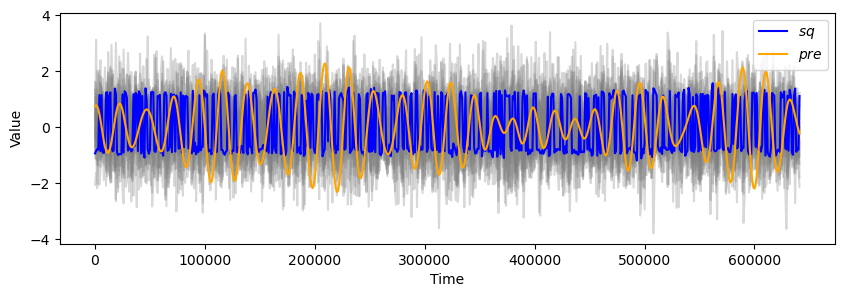

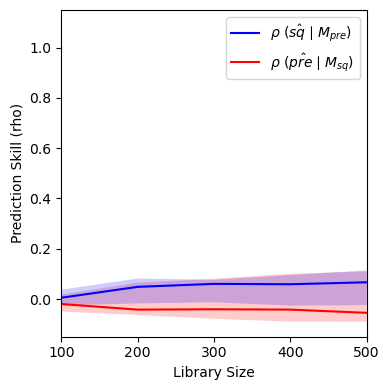

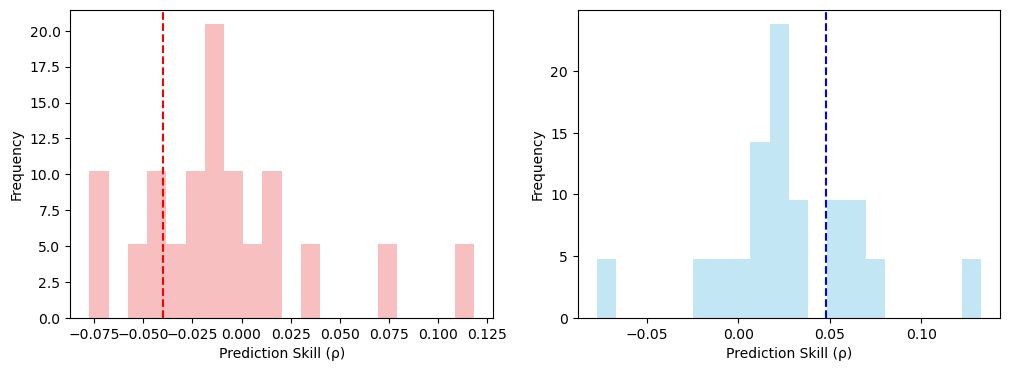

(False, False)


In [48]:
from toolbox import significant_test as st
import importlib
importlib.reload(st)



ccm_out, ran_ccm_list_xy, test_result=st.ccm_significance_test_v3(
    df_sq, 
    df_pre,
    E=6, 
    tau=-5, 
    n_ran=20, 
    libSizes="100 200 300 400 500",
    Tp=0,
    sample=20,
    random=True,
    uni_dir=False,
    showPlot=True)

print(test_result)

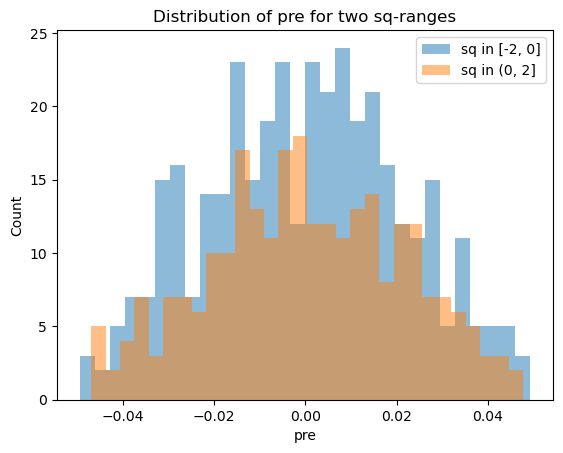

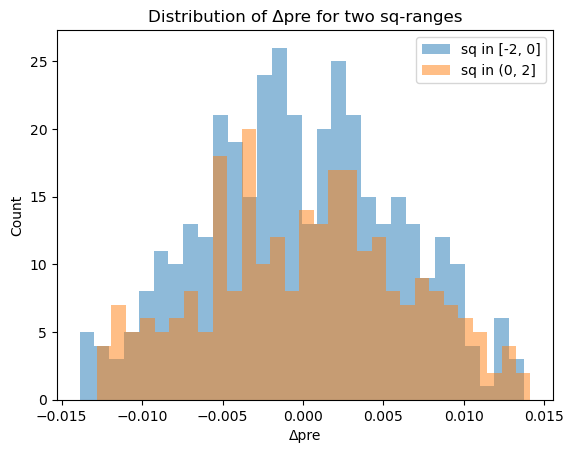

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- assume df_pre and df_sq are already defined ---
# df_pre has columns ['age','pre'], df_sq has ['age','sq'] and identical indexing

# Part 1: histograms of pre for sq in [-2,0] vs (0,2]
mask1 = (df_sq['sq'] >= -2) & (df_sq['sq'] <= 0)
mask2 = (df_sq['sq'] >  0) & (df_sq['sq'] <= 2)

pre1 = df_pre.loc[mask1, 'pre']
pre2 = df_pre.loc[mask2, 'pre']

plt.figure()
plt.hist(pre1, bins=30, alpha=0.5, label='sq in [-2, 0]')
plt.hist(pre2, bins=30, alpha=0.5, label='sq in (0, 2]')
plt.xlabel('pre')
plt.ylabel('Count')
plt.title('Distribution of pre for two sq‐ranges')
plt.legend()
plt.show()


# Part 2: histograms of diff(pre) aligned to sq[1:]
pre_vals   = df_pre['pre'].values
diff_pre   = np.diff(pre_vals)
sq_aligned = df_sq['sq'].values[1:]  # diff[i] corresponds to transition into index i+1

mask1_d = (sq_aligned >= -2) & (sq_aligned <= 0)
mask2_d = (sq_aligned >  0) & (sq_aligned <= 2)

diff1 = diff_pre[mask1_d]
diff2 = diff_pre[mask2_d]

plt.figure()
plt.hist(diff1, bins=30, alpha=0.5, label='sq in [-2, 0]')
plt.hist(diff2, bins=30, alpha=0.5, label='sq in (0, 2]')
plt.xlabel('Δpre')
plt.ylabel('Count')
plt.title('Distribution of Δpre for two sq‐ranges')
plt.legend()
plt.show()


In [20]:
import numpy as np
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode

# Initialize Plotly for offline use
init_notebook_mode(connected=True)

# Ensure df_sq is present
if 'df_sq' not in globals():
    raise NameError("DataFrame 'df_sq' not found. Please ensure you have loaded your DataFrame 'df_sq' with a 'sq' column.")

# Extract the 'sq' series
sq = df_sq['sq'].values

# Embedding parameters
E = 3
tau = 10

# Compute embedding dimension
N = len(sq)
M = N - (E - 1) * tau

# Build the delay embedding matrix
embedded = np.zeros((M, E))
for i in range(M):
    for j in range(E):
        embedded[i, j] = sq[i + j * tau]

# Assign axes
x, y, z = embedded[:, 0], embedded[:, 1], embedded[:, 2]

# Create 3D scatter plot
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=3)
)

layout = go.Layout(
    title=f'Shadow Manifold (E={E}, τ={tau})',
    scene=dict(
        xaxis=dict(title='sq(t)'),
        yaxis=dict(title=f'sq(t+{tau})'),
        zaxis=dict(title=f'sq(t+{2*tau})')
    )
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()


In [21]:
import numpy as np
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode

# Initialize Plotly for offline use
init_notebook_mode(connected=True)

# Ensure df_sq is present
if 'df_sq' not in globals():
    raise NameError("DataFrame 'df_sq' not found. Please ensure you have loaded your DataFrame 'df_sq' with a 'sq' column.")

# Extract the 'sq' series
sq = df_sq['sq'].values

# Embedding parameters (same as before)
E = 3
tau = 5

# Compute embedding length
N = len(sq)
M = N - (E - 1) * tau

# Build the delay embedding matrix
embedded = np.zeros((M, E))
for i in range(M):
    for j in range(E):
        embedded[i, j] = sq[i + j * tau]

# Use first two dimensions for 2D plot
x = embedded[:, 0]
y = embedded[:, 1]

# Create 2D scatter plot
trace = go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(size=5)
)

layout = go.Layout(
    title=f'2D Shadow Manifold (sq(t) vs sq(t+{tau}))',
    xaxis=dict(title='sq(t)'),
    yaxis=dict(title=f'sq(t+{tau})')
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()


In [ ]:
# save df_sq and df_pre to csv under 'test/', please create the folder first
df_sq.to_csv(r"D:\VScode\bipolar_seesaw_CCM\test\df_sq.csv", index=False)
df_pre.to_csv(r"D:\VScode\bipolar_seesaw_CCM\test\df_pre.csv", index=False)

# read the csv file
df_sq = pd.read_csv(r"D:\VScode\bipolar_seesaw_CCM\test\df_sq.csv")
df_pre = pd.read_csv(r"D:\VScode\bipolar_seesaw_CCM\test\df_pre.csv")

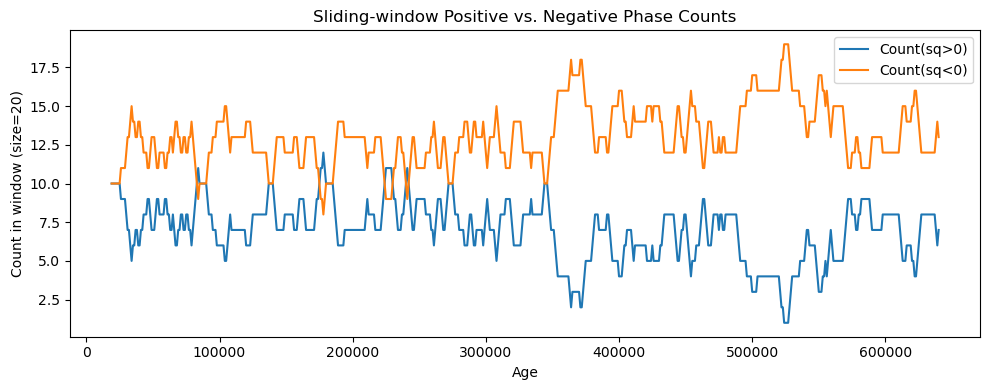

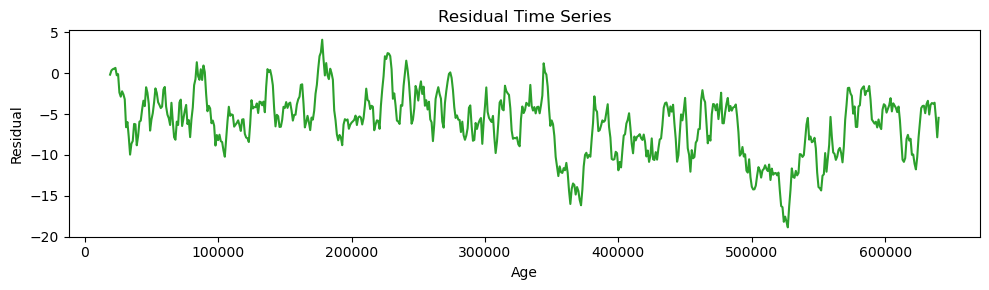

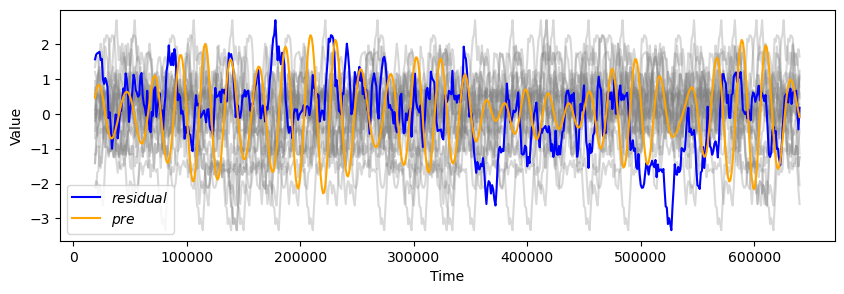

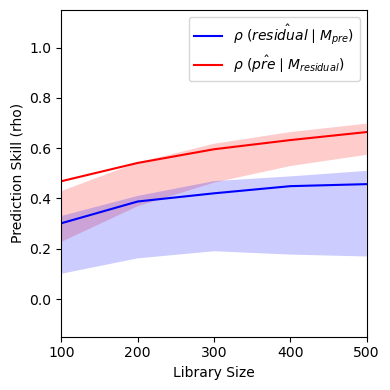

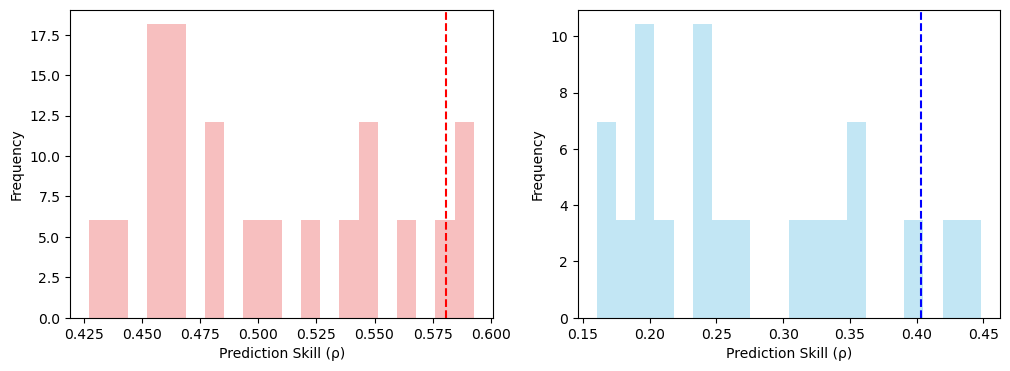

(False, False)


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from toolbox import significant_test as st
import importlib
importlib.reload(st)

# --- Parameters ---
window_size = 20

# --- 1) Compute moving‐window phase counts ---
sq_vals = df_sq['sq'].values
N       = len(sq_vals)
n_win   = N - window_size + 1

pos_counts = np.empty(n_win, dtype=int)
neg_counts = np.empty(n_win, dtype=int)
# For plotting, we can assign each window an “age” at its right edge:
ages = df_sq['age'].values[window_size-1 : ]

for i in range(n_win):
    w = sq_vals[i : i + window_size]
    pos_counts[i] = np.sum(w >  0)
    neg_counts[i] = np.sum(w <  0)

# --- 2) Plot positive vs. negative counts ---
plt.figure(figsize=(10,4))
plt.plot(ages, pos_counts, label='Count(sq>0)', color='tab:blue')
plt.plot(ages, neg_counts, label='Count(sq<0)', color='tab:orange')
plt.xlabel('Age')
plt.ylabel('Count in window (size=20)')
plt.title('Sliding‐window Positive vs. Negative Phase Counts')
plt.legend()
plt.tight_layout()
plt.show()

# --- 3) Compute and plot the “residual” time series ---
residual = pos_counts - neg_counts

# adding some noise to the residual
white_noise = np.random.normal(0, 0.5, len(residual))
residual = residual + white_noise

plt.figure(figsize=(10,3))
plt.plot(ages, residual, label='Residual = pos_counts - neg_counts', color='tab:green')
plt.xlabel('Age')
plt.ylabel('Residual')
plt.title('Residual Time Series')
plt.tight_layout()
plt.show()

# --- 4) Prepare for CCM: align residual and precession ---
#   Residual has length n_win, so drop the first (window_size-1) rows of df_pre:
df_pre_aligned = df_pre.iloc[window_size-1 : ].reset_index(drop=True)

#   Make a small DataFrame for residual
df_residual = pd.DataFrame({
    'age':      ages,
    'residual': residual
})

# --- 5) Run your CCM significance test ---
ccm_out, ran_ccm_list_xy, test_result = st.ccm_significance_test_v2(
    df_residual,           # now our “driver” series
    df_pre_aligned,        # target (precession), same length as residual
    E=6,
    tau=-5,
    n_ran=20,
    libSizes="100 200 300 400 500",
    Tp=0,
    sample=20,
    random=True,
    uni_dir=False,
    showPlot=True
)

print(test_result)


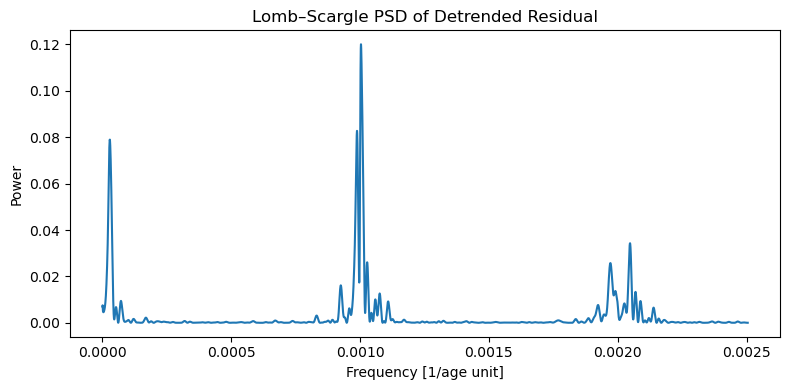

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
from astropy.timeseries import LombScargle

# --- Assume df_residual exists with 'age' (time) and 'residual' columns ---
t = df_residual['age'].values
y = df_residual['residual'].values

# 1) Linearly detrend the residual
y_detrended = detrend(y)

# 2) Compute Lomb-Scargle periodogram (power spectral density)
ls = LombScargle(t, y_detrended)
frequency, power = ls.autopower()

# 3) Plot PSD
plt.figure(figsize=(8, 4))
plt.plot(frequency, power)
# set x lim to 0 to 0.0001
# plt.xlim(0, 0.0001)
plt.xlabel('Frequency [1/age unit]')
plt.ylabel('Power')
plt.title('Lomb–Scargle PSD of Detrended Residual')
plt.tight_layout()
plt.show()


TE(pre→residual) = 0.1523 bits


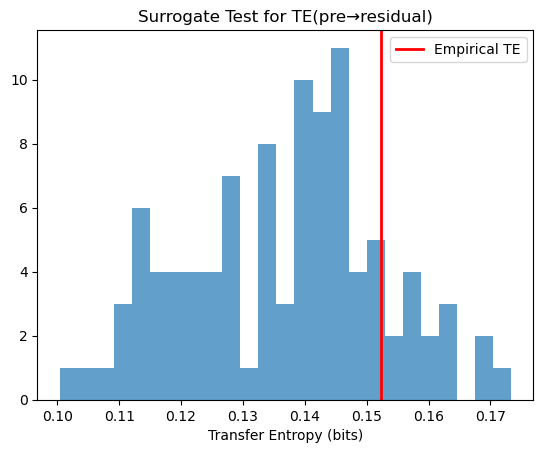

p-value = 0.150


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy  # correct import! :contentReference[oaicite:0]{index=0}

# — assume df_pre_aligned['pre'] and df_residual['residual'] exist and are same length
x = df_pre_aligned['pre'].values      # source (precession)
y = df_residual['residual'].values    # target (residual)

# 1) Discretize into nbins equiprobable bins
nbins = 8
xbins = np.histogram_bin_edges(x, bins=nbins)
ybins = np.histogram_bin_edges(y, bins=nbins)
x_disc = np.digitize(x, xbins) - 1
y_disc = np.digitize(y, ybins) - 1

# 2) Compute TE from pre→residual with history length k=1
#    note: drop last/first sample to align t→t+1
te_xy = transfer_entropy(x_disc[:-1], y_disc[1:], k=1)
print(f"TE(pre→residual) = {te_xy:.4f} bits")

# 3) Permutation‐based surrogate test
n_surr = 100
te_null = np.zeros(n_surr)
for i in range(n_surr):
    xs = np.random.permutation(x_disc)
    te_null[i] = transfer_entropy(xs[:-1], y_disc[1:], k=1)

# 4) Plot null distribution
plt.hist(te_null, bins=25, alpha=0.7)
plt.axvline(te_xy, color='r', lw=2, label='Empirical TE')
plt.xlabel('Transfer Entropy (bits)')
plt.legend()
plt.title('Surrogate Test for TE(pre→residual)')
plt.show()

# 5) Compute p-value
p_value = np.mean(te_null >= te_xy)
print(f"p-value = {p_value:.3f}")


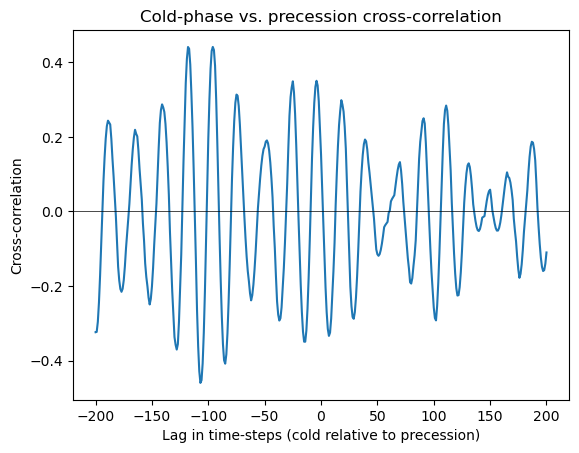

In [26]:
cold = (df_sq['sq'] < 0).astype(float)
pre  = (df_pre['pre'] - df_pre['pre'].mean()) / df_pre['pre'].std()


import numpy as np
import matplotlib.pyplot as plt

cold = (df_sq['sq'] < 0).astype(float).values
pre  = (df_pre['pre'] - df_pre['pre'].mean()) / df_pre['pre'].std()

maxlag = 200  # choose based on your sampling (e.g. ±200 kyr)
lags = np.arange(-maxlag, maxlag+1)
ccf  = []
for lag in lags:
    # shift cold forward by “lag” so that positive lag means “cold after precession”
    c = np.corrcoef(np.roll(cold, -lag)[maxlag:-maxlag],
                    pre          [maxlag:-maxlag])[0,1]
    ccf.append(c)

plt.plot(lags, ccf)
plt.axhline(0, color='k', lw=0.5)
plt.xlabel('Lag in time‐steps (cold relative to precession)')
plt.ylabel('Cross‐correlation')
plt.title('Cold‐phase vs. precession cross‐correlation')
plt.show()



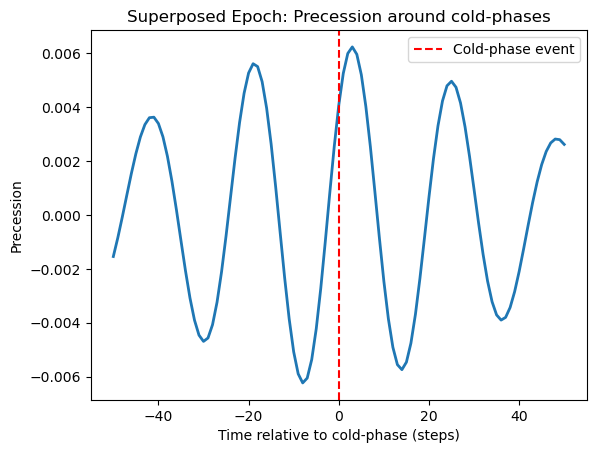

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Identify event indices
events    = df_sq.index[df_sq['sq'] < 0]          # or whichever criterion you like
half_win  = 50                                    # e.g. ±50 time‐steps around each event
windows   = []

for e in events:
    if e-half_win >= 0 and e+half_win < len(df_pre):
        window = df_pre['pre'].iloc[e-half_win:e+half_win+1].values
        windows.append(window)

# 2) Build the composite
composite = np.vstack(windows)
mean_compo = composite.mean(axis=0)

# 3) Plot
times = np.arange(-half_win, half_win+1)
plt.plot(times, mean_compo, lw=2)
plt.axvline(0, color='r', ls='--', label='Cold‐phase event')
plt.xlabel('Time relative to cold‐phase (steps)')
plt.ylabel('Precession')
plt.title('Superposed Epoch: Precession around cold‐phases')
plt.legend()
plt.show()


In [ ]:
from scipy.stats import chi2_contingency

# 1) Compute Δpre
dpre = np.diff(df_pre['pre'])
# Align mask to same length as df_sq (drop first row of sq)
cold_mask = (df_sq['sq'].iloc[1:] < 0)
dec_mask  = (dpre < 0)

# 2) Build table
# a = cold & decreasing; b = cold & increasing; c = warm & decreasing; d = warm & increasing
a = np.sum( cold_mask & dec_mask)
b = np.sum( cold_mask & ~dec_mask)
c = np.sum(~cold_mask & dec_mask)
d = np.sum(~cold_mask & ~dec_mask)
table = np.array([[a, b],
                  [c, d]])

print("Contingency table:\n", table)

# 3) Test
chi2, p, dof, expected = chi2_contingency(table)
print(f"χ²={chi2:.2f}, p={p:.3f}")


Contingency table:
 [[239 178]
 [ 79 144]]
χ²=26.98, p=0.000


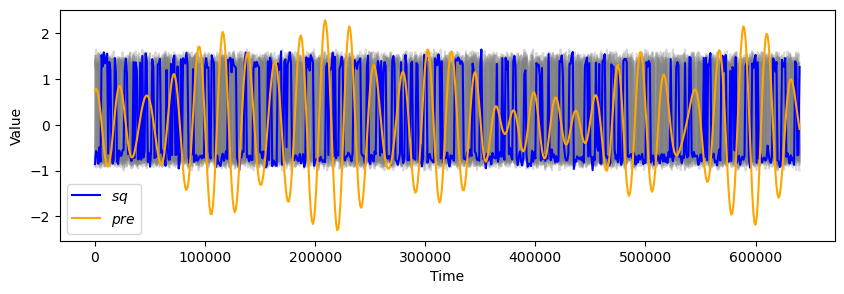

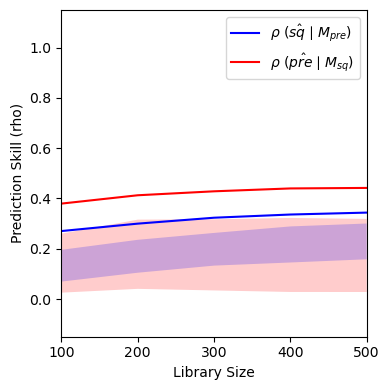

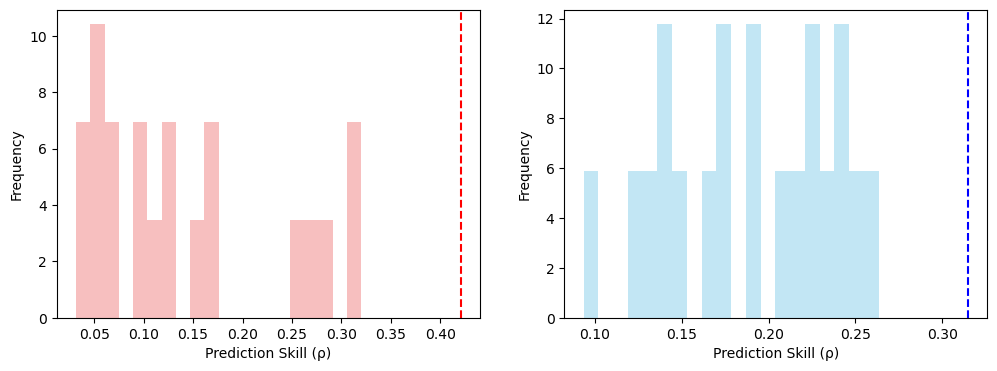

In [ ]:
from toolbox import significant_test as st
import importlib
importlib.reload(st)



ccm_out, ran_ccm_list_xy, test_result=st.ccm_significance_test_v2(
    df_sq, 
    df_pre,
    E=6, 
    tau=-5, 
    n_ran=20, 
    libSizes="100 200 300 400 500",
    Tp=0,
    sample=20,
    random=True,
    uni_dir=False,
    showPlot=True)

Best threshold = gt 0.352,  F1 = 0.24


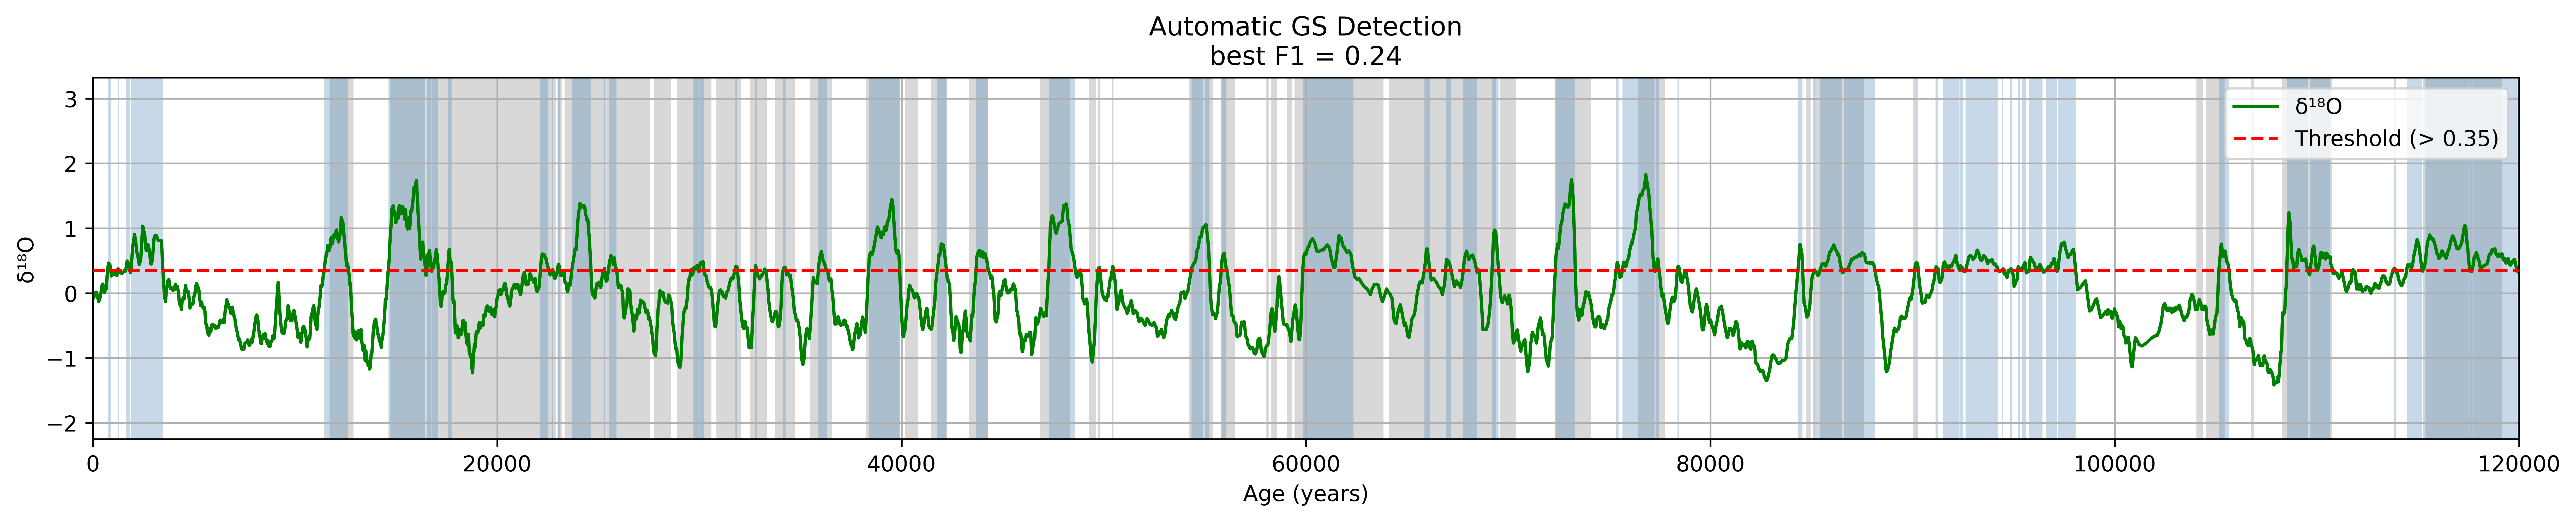

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby

# ------------------------------------------------------------------
# 1.  YOUR GS TABLE  (unchanged – keep it exactly as you supplied)
# ------------------------------------------------------------------
data = {
    "event": ["GS-1", "GS-2.1c", "GS-2.2", "GS-3", "GS-4", "GS-5.1", "GS-5.2", "GS-6",
              "GS-7", "GS-8", "GS-9", "GS-10", "GS-11", "GS-12", "GS-13", "GS-14",
              "GS-15.1", "GS-15.2", "GS-16.1", "GS-16.2", "GS-17.1", "GS-17.2",
              "GS-18", "GS-19.1", "GS-19.2", "GS-20", "GS-21.1", "GS-21.2", "GS-22",
              "GS-23.1", "GS-23.2", "GS-24.1", "GS-24.2", "GS-25", "GS-26"],
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040, 104520, 106750, 108280, 115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380, 105440, 106900, 110640, 119140]
}

# ------------------------------------------------------------------
# 2.  Boolean "ground-truth" vector: 1⇔inside any GS interval, 0⇔otherwise
# ------------------------------------------------------------------
ages = new_df['age'].values
d18O = new_df['d18O'].values

is_gs_true = np.zeros_like(ages, dtype=bool)
for s, e in zip(data["start"], data["end"]):
    is_gs_true |= (ages >= s) & (ages <= e)          # element-wise “OR”

# ------------------------------------------------------------------
# 3.  Scan candidate thresholds and pick the one that maximises F1
#     • We try both directions (δ¹⁸O > y  *or*  δ¹⁸O < y)
# ------------------------------------------------------------------
def f1(pred, true):
    tp = np.sum(pred & true)
    fp = np.sum(pred & ~true)
    fn = np.sum(~pred & true)
    return 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0.0

# Use a grid of percentiles as candidate cut-offs
cands = np.percentile(d18O, np.linspace(5, 95, 181))   # ≈0.5 % steps

best_thr, best_f1, best_dir = None, -1, None
for direction in ('gt', 'lt'):                         # greater-than OR less-than
    for thr in cands:
        pred = d18O > thr if direction == 'gt' else d18O < thr
        score = f1(pred, is_gs_true)
        if score > best_f1:
            best_thr, best_f1, best_dir = thr, score, direction

# ------------------------------------------------------------------
# 4.  Build contiguous predicted GS segments for plotting
# ------------------------------------------------------------------
is_gs_pred = d18O > best_thr if best_dir == 'gt' else d18O < best_thr

segments = []                                          # (start_age, end_age) pairs
for k, grp in groupby(enumerate(is_gs_pred), key=lambda x: x[1]):
    if k:                                              # only True segments
        grp = list(grp)
        segments.append((ages[grp[0][0]], ages[grp[-1][0]]))

print(f"Best threshold = {best_dir} {best_thr:.3f},  F1 = {best_f1:.2f}")

# ------------------------------------------------------------------
# 5.  Plot everything
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(20, 3), dpi=600)

# a) Official GS intervals (grey)
for s, e in zip(data["start"], data["end"]):
    ax.axvspan(s, e, color='grey', alpha=0.30, zorder=0, linewidth=0)

# b) Predicted GS intervals from δ¹⁸O (blue)
for s, e in segments:
    ax.axvspan(s, e, color='steelblue', alpha=0.30, zorder=1, linewidth=0)

# c) δ¹⁸O curve
ax.plot(ages, d18O, color='green', label='δ¹⁸O', zorder=2)

# d) Horizontal threshold
ax.axhline(best_thr, color='red', linestyle='--',
           label=f"Threshold ({'>' if best_dir=='gt' else '<'} {best_thr:.2f})", zorder=3)

# Cosmetic bits
ax.set_xlabel('Age (years)')
ax.set_ylabel('δ¹⁸O')
ax.set_xlim(0, 120000)
ax.set_title(f"Automatic GS Detection\nbest F1 = {best_f1:.2f}")
ax.grid(True)
ax.legend(loc='upper right')

plt.show()


In [26]:
# for column d18O in new_df, find the quantiles that 0.35 corresponds to

quantile_0_35 = np.percentile(new_df['d18O'],80)
print(f"0.35 quantile of d18O: {quantile_0_35}")

0.35 quantile of d18O: 0.45055558476972235


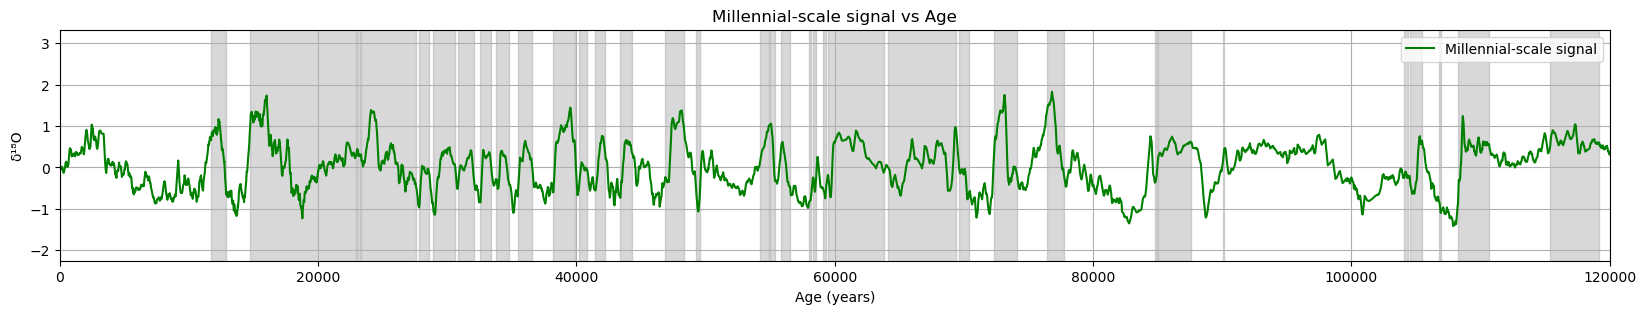

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


data = {
    "event": ["GS-1", "GS-2.1c", "GS-2.2", "GS-3", "GS-4", "GS-5.1", "GS-5.2", "GS-6", "GS-7", "GS-8",
              "GS-9", "GS-10", "GS-11", "GS-12", "GS-13", "GS-14", "GS-15.1", "GS-15.2", "GS-16.1", "GS-16.2",
              "GS-17.1", "GS-17.2", "GS-18", "GS-19.1", "GS-19.2", "GS-20", "GS-21.1", "GS-21.2", "GS-22",
              "GS-23.1", "GS-23.2", "GS-24.1", "GS-24.2", "GS-25", "GS-26"],
    # note: these are the *start* times of the GS events
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040, 104520, 106750, 108280, 115370],
    # and these are the *end* times
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380, 105440, 106900, 110640, 119140]
}


# plot
plt.figure(figsize=(20, 3))

# add grey spans for each GS event
for s, e in zip(data["start"], data["end"]):
    plt.axvspan(s, e, color='grey', alpha=0.3)

# millennial-scale signal
plt.plot(new_df['age'], new_df['d18O'],
         label='Millennial‐scale signal', color='green')

plt.xlabel('Age (years)')
plt.ylabel('δ¹⁸O')
plt.title('Millennial‐scale signal vs Age')
plt.legend(loc='upper right')
plt.grid(True)
# reverse the y-axis
# plt.gca().invert_yaxis()
plt.xlim(0, 120000)

plt.show()

